# l'analyse l'exicale 


Chargement et Filtrage Expert...
Mots analysés (après filtrage) : 24424 (Gaza) vs 14666 (Ukraine)


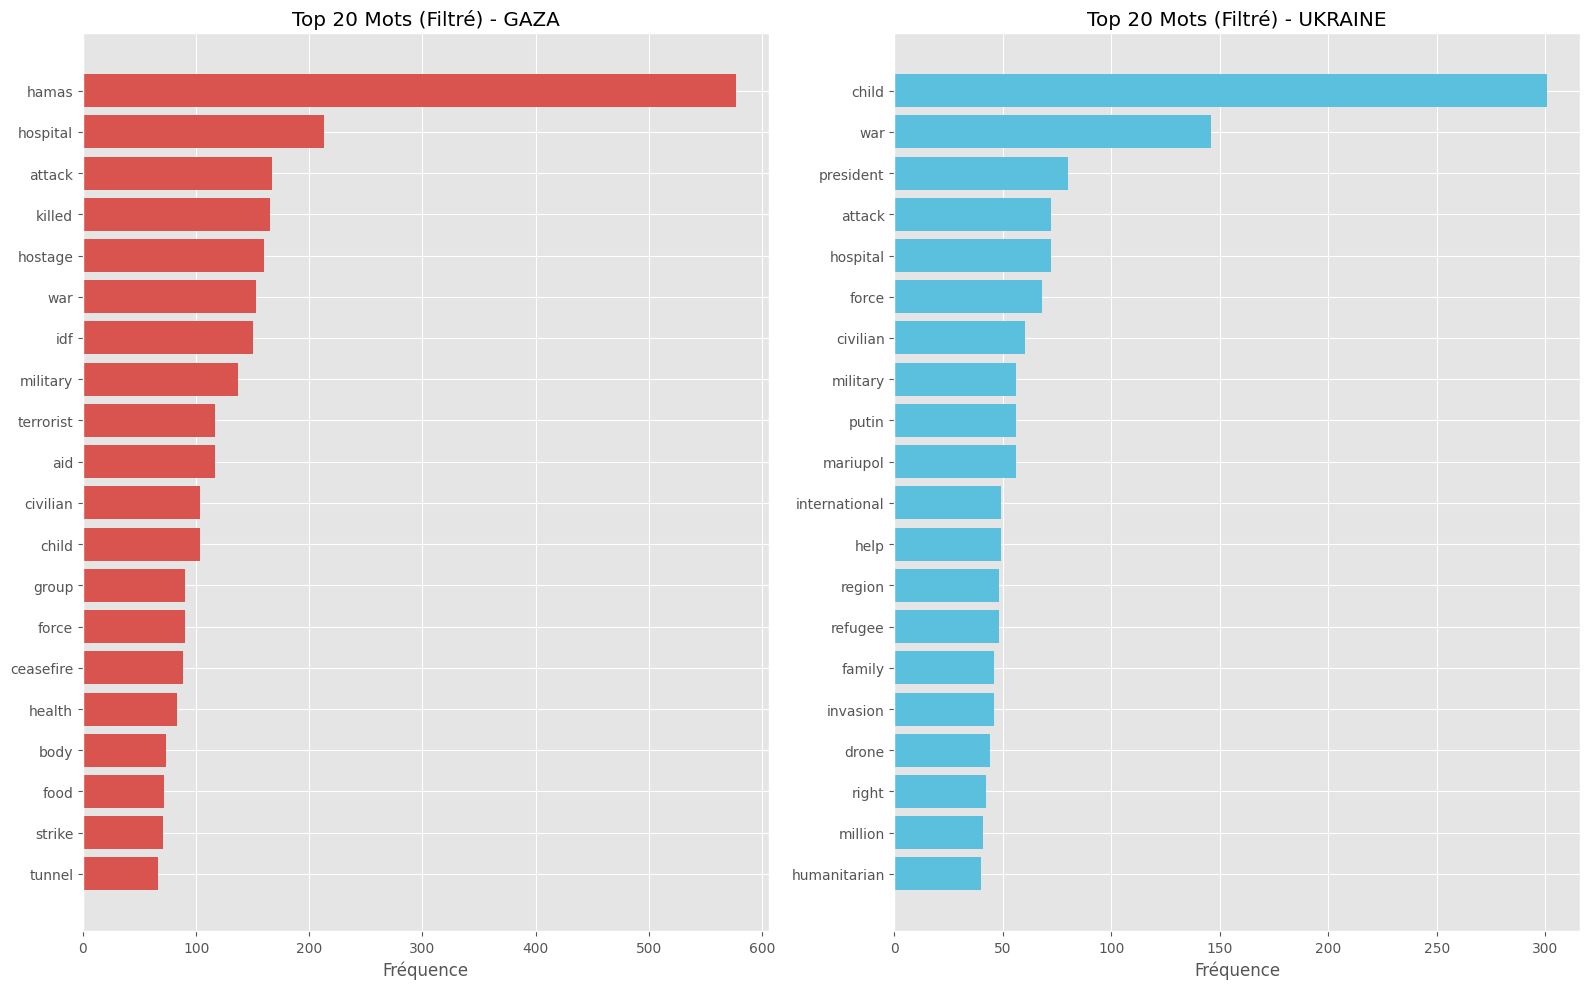

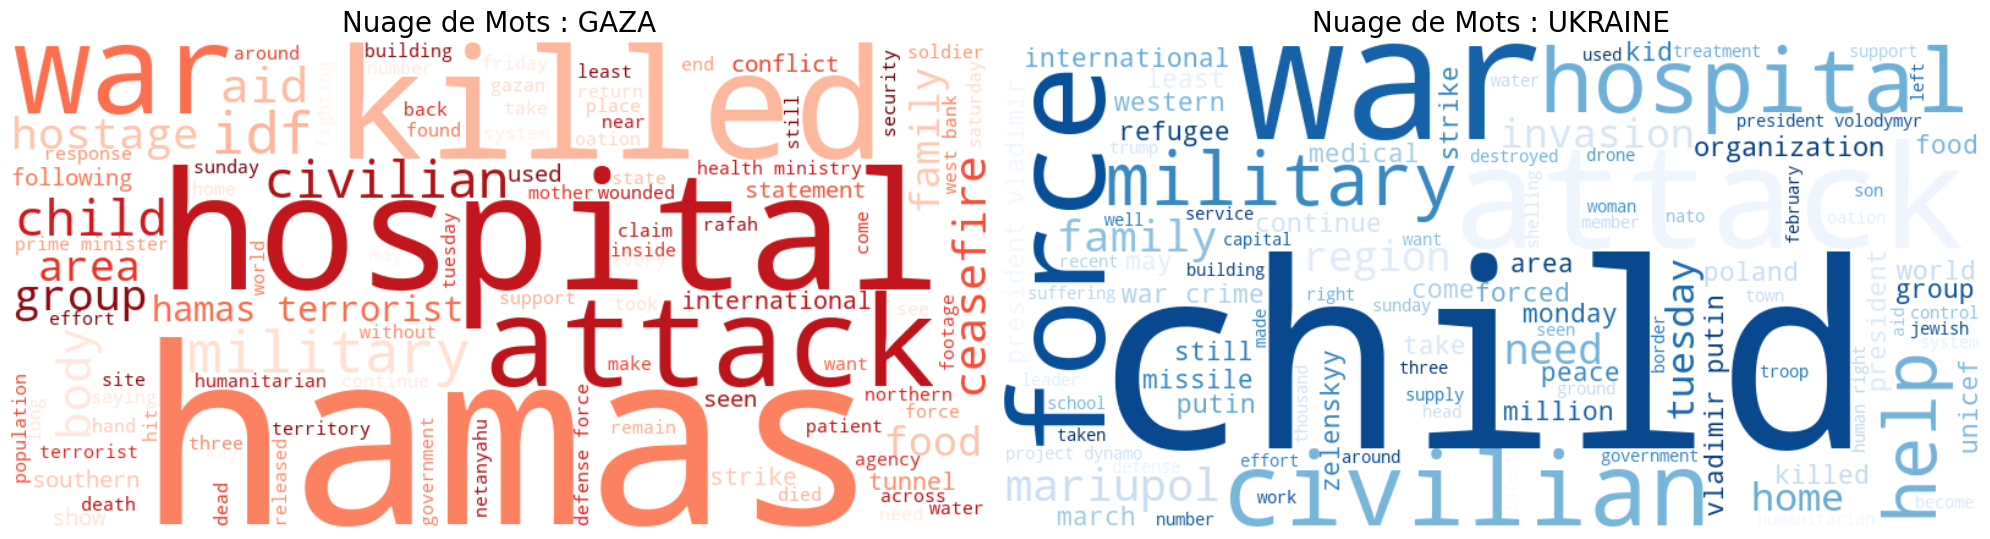


=== ANALYSE FINE : GAZA ===
TOP 10 ADJECTIFS : [('military', 111), ('southern', 57), ('international', 54), ('least', 46), ('medical', 40), ('dead', 39), ('northern', 33), ('humanitarian', 32), ('civilian', 31), ('terrorist', 26)]
TOP 10 VERBES    : [('kill', 183), ('take', 122), ('include', 104), ('see', 83), ('use', 74), ('accord', 68), ('add', 67), ('show', 65), ('hold', 59), ('come', 59)]
TOP 10 COUPLES (Cooccurrences) : [(('hamas', 'terrorist'), 56), (('prime', 'minister'), 43), (('health', 'ministry'), 41), (('defense', 'force'), 31), (('west', 'bank'), 27), (('minister', 'benjamin'), 25), (('benjamin', 'netanyahu'), 23), (('khan', 'younis'), 21), (('yahya', 'sinwar'), 17), (('woman', 'child'), 17)]

=== ANALYSE FINE : UKRAINE ===
TOP 10 ADJECTIFS : [('military', 49), ('humanitarian', 37), ('medical', 28), ('western', 27), ('late', 22), ('least', 22), ('international', 19), ('large', 18), ('civilian', 18), ('recent', 17)]
TOP 10 VERBES    : [('take', 65), ('include', 58), ('cont

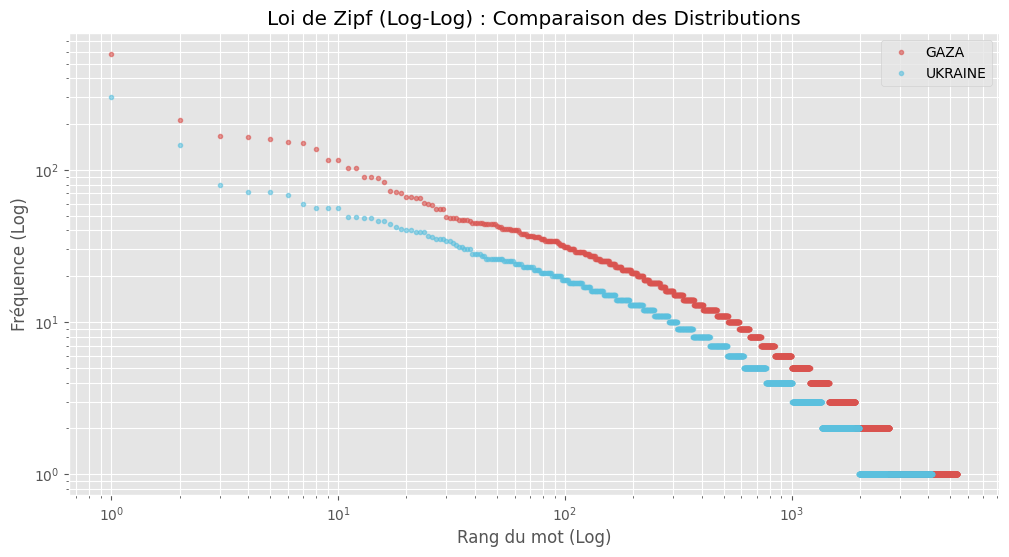

In [15]:
import json
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from nltk import ngrams


# Téléchargement si nécessaire
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# --- CONFIGURATION : LA LISTE NOIRE ---
# définit ce qui est du "bruit" pour ce projet.
def get_expert_stopwords():
    base_stops = set(stopwords.words('english'))
    
    # 1. Verbes de reportage (Bruit journalistique)
    reporting_verbs = {'say', 'said', 'told', 'tell', 'reported', 'report', 
                       'according', 'added', 'stated', 'noted', 'announced'}
    
    # 2. Entités du Sujet (Bruit thématique - on sait de quoi on parle)
    # On les enlève pour voir les adjectifs et thèmes cachés derrière
    topic_entities = {'gaza', 'israel', 'israeli', 'palestine', 
                      'palestinian', 'ukraine', 'ukrainian', 'russia', 
                      'russian', 'kyiv', 'moscow', 'strip'}
    
    # 3. Mots vides courants (Bruit statistique)
    noise_words = {'also', 'one', 'two', 'year', 'new', 'would', 'could', 
                   'first', 'last', 'many', 'people', 'since', 'including', 
                   'country', 'part', 'official', 'city', 'day', 'time', 'october','video','week','even','plan','month'}
    
    # Union de tous les filtres
    return base_stops.union(reporting_verbs).union(topic_entities).union(noise_words)

# --- CHARGEMENT ET FILTRAGE ---
def charger_et_filtrer(chemin):
    with open(chemin, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    expert_stops = get_expert_stopwords()
    all_tokens = []
    
    for art in data:
        # On récupère la vue lexicale propre
        raw_tokens = art['lexical_view']
        # FILTRAGE EXPERT : On ne garde que les mots riches de sens
        clean_tokens = [w for w in raw_tokens 
                        if w not in expert_stops and len(w) > 2 and not w.isdigit()]
        all_tokens.extend(clean_tokens)
        
    return all_tokens

# --- FONCTIONS GRAPHIQUES (Mises à jour) ---

def comparer_top_mots(tokens_gaza, tokens_ukraine, top_n=20):
    fig, axes = plt.subplots(1, 2, figsize=(16, 10))
    colors = {'GAZA': '#d9534f', 'UKRAINE': '#5bc0de'}
    
    for ax, (label, tokens) in zip(axes, [('GAZA', tokens_gaza), ('UKRAINE', tokens_ukraine)]):
        counter = Counter(tokens)
        most_common = counter.most_common(top_n)
        words, counts = zip(*most_common)
        
        ax.barh(words, counts, color=colors[label])
        ax.set_title(f"Top {top_n} Mots (Filtré) - {label}")
        ax.invert_yaxis()
        ax.set_xlabel("Fréquence")

    plt.tight_layout()
    plt.savefig("images/comparaison_top_mots_expert.png")
    plt.show()

def generer_wordclouds(tokens_gaza, tokens_ukraine):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    for ax, (label, tokens) in zip(axes, [('GAZA', tokens_gaza), ('UKRAINE', tokens_ukraine)]):
        text = " ".join(tokens)
        wc = WordCloud(width=800, height=400, background_color='white', 
                       colormap='Reds' if label == 'GAZA' else 'Blues',
                       max_words=100).generate(text)
        
        ax.imshow(wc, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f"Nuage de Mots : {label}", fontsize=20)
    
    plt.tight_layout()
    plt.savefig("images/comparaison_wordclouds_expert.png")
    plt.show()


    
# --- 4. LOI DE ZIPF (VALIDATION SCIENTIFIQUE - Lab 3) ---
def verifier_loi_zipf(tokens_gaza, tokens_ukraine):
    plt.figure(figsize=(12, 6))
    
    for label, tokens in [('GAZA', tokens_gaza), ('UKRAINE', tokens_ukraine)]:
        counts = [count for word, count in Counter(tokens).most_common()]
        rangs = range(1, len(counts) + 1)
        
        plt.loglog(rangs, counts, marker=".", linestyle="none", label=label, color=COLORS[label], alpha=0.6)
    
    plt.title("Loi de Zipf (Log-Log) : Comparaison des Distributions")
    plt.xlabel("Rang du mot (Log)")
    plt.ylabel("Fréquence (Log)")
    plt.legend()
    plt.grid(True, which="both", ls="-")
    plt.savefig("images/loi_zipf.png")
    plt.show()

def analyser_grammaire_et_ngrams(fichier_json, label):
    with open(fichier_json, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    adjectifs = []
    verbes = []
    bigrams_list = []
    
    expert_stops = get_expert_stopwords() # On réutilise notre filtre
    
    for art in data:
        # 1. Analyse Grammaticale (Via Structural View)
        for phrase in art['structural_view']:
            for token in phrase:
                mot = token['l'] # Lemme
                tag = token['t'] # Tag POS
                
                if mot not in expert_stops and len(mot) > 2:
                    # Si c'est un Adjectif (Tag commence par J)
                    if tag.startswith('J'):
                        adjectifs.append(mot)
                    # Si c'est un Verbe (Tag commence par V)
                    elif tag.startswith('V'):
                        verbes.append(mot)

        # 2. Cooccurrences (Bigrammes) sur la vue lexicale
        tokens_propres = [w for w in art['lexical_view'] if w not in expert_stops and len(w) > 2]
        bigrams = ngrams(tokens_propres, 2)
        bigrams_list.extend(bigrams)

    # Affichage des Résultats
    print(f"\n=== ANALYSE FINE : {label} ===")
    print(f"TOP 10 ADJECTIFS : {Counter(adjectifs).most_common(10)}")
    print(f"TOP 10 VERBES    : {Counter(verbes).most_common(10)}")
    print(f"TOP 10 COUPLES (Cooccurrences) : {Counter(bigrams_list).most_common(10)}")



# --- EXÉCUTION ---
if __name__ == "__main__":
    print("Chargement et Filtrage Expert...")
    mots_gaza = charger_et_filtrer('corpus/corpus_gaza_pretraiter.json')
    mots_ukraine = charger_et_filtrer('corpus/corpus_ukraine_pretraiter.json')
    
    print(f"Mots analysés (après filtrage) : {len(mots_gaza)} (Gaza) vs {len(mots_ukraine)} (Ukraine)")
    
    # 1. Comparaison des Top Mots
    comparer_top_mots(mots_gaza, mots_ukraine)
    
    # 2. Nuages de Mots
    generer_wordclouds(mots_gaza, mots_ukraine)
    # 3. Analyse Grammaticale et N-grammes
    analyser_grammaire_et_ngrams('corpus/corpus_gaza_pretraiter.json', 'GAZA')
    analyser_grammaire_et_ngrams('corpus/corpus_ukraine_pretraiter.json', 'UKRAINE')

    # 4. Loi de Zipf
    verifier_loi_zipf(mots_gaza, mots_ukraine)

In [18]:
# =================================================================
# PROJET NLP : GÉNÉRATEUR DE RAPPORTS D'ANALYSE LEXICALE
# =================================================================
# Objectif : Répondre point par point aux 4 questions du Dr. KALI ALI
# Sortie : Tableaux comparatifs clairs (Gaza vs Ukraine)
# =================================================================

import json
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
import nltk
from nltk import ngrams
import matplotlib.pyplot as plt

# Configuration de l'affichage pour que les tableaux soient jolis
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 4)
pd.set_option('display.width', 1000)

# Téléchargement silencieux
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# --- 1. FILTRAGE EXPERT (La base de tout) ---
def get_expert_stopwords():
    base_stops = set(stopwords.words('english'))
    reporting_verbs = {'say', 'said', 'told', 'tell', 'reported', 'report', 
                       'according', 'added', 'stated', 'noted', 'announced'}
    topic_entities = {'gaza', 'israel', 'israeli', 'palestine', 'palestinian', 
                      'ukraine', 'ukrainian', 'russia', 'russian', 'kyiv', 'moscow', 'strip'}
    noise_words = {'also', 'one', 'two', 'year', 'new', 'would', 'could', 'first', 
                   'last', 'many', 'people', 'since', 'including', 'country', 'part', 
                   'official', 'city', 'day', 'time', 'october', 'video', 'week', 'month', 'make'}
    return base_stops.union(reporting_verbs).union(topic_entities).union(noise_words)

# --- 2. MOTEUR D'ANALYSE (Extraction des Données) ---
def analyser_corpus(chemin_json):
    with open(chemin_json, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    expert_stops = get_expert_stopwords()
    stats = {
        "mots": [],
        "adjectifs": [],
        "verbes": [],
        "bigrams": [],
        "trigrams": []
    }
    
    for art in data:
        # A. Mots simples (Lexical View)
        tokens_propres = [w for w in art['lexical_view'] 
                          if w not in expert_stops and len(w) > 2 and not w.isdigit()]
        stats["mots"].extend(tokens_propres)
        
        # B. Grammaire (Structural View)
        for phrase in art['structural_view']:
            for token in phrase:
                mot = token['l']
                tag = token['t']
                if mot not in expert_stops and len(mot) > 2:
                    if tag.startswith('J'): stats["adjectifs"].append(mot)
                    elif tag.startswith('V'): stats["verbes"].append(mot)
        
        # C. N-Grams
        stats["bigrams"].extend(ngrams(tokens_propres, 2))
        stats["trigrams"].extend(ngrams(tokens_propres, 3))
        
    return stats

# --- 3. AFFICHAGE COMPARATIF (Le Cœur du Rapport) ---
def afficher_tableau_comparatif(titre, liste_gaza, liste_ukraine, top_n=15):
    print(f"\n{'='*80}")
    print(f"  {titre.upper()}")
    print(f"{'='*80}")
    
    # Création des compteurs
    count_g = Counter(liste_gaza).most_common(top_n)
    count_u = Counter(liste_ukraine).most_common(top_n)
    
    # Création d'un DataFrame joli pour comparer côte à côte
    df = pd.DataFrame({
        'GAZA (Terme)': [k for k,v in count_g],
        'Freq (G)': [v for k,v in count_g],
        ' | ': ['|'] * top_n, # Séparateur visuel
        'UKRAINE (Terme)': [k for k,v in count_u],
        'Freq (U)': [v for k,v in count_u]
    })
    
    print(df.to_string(index=False))

# --- 4. EXÉCUTION ORDONNÉE PAR QUESTION ---
if __name__ == "__main__":
    print("⏳ Chargement et Analyse des données en cours...")
    data_gaza = analyser_corpus('corpus/corpus_gaza_pretraiter.json')
    data_ukraine = analyser_corpus('corpus/corpus_ukraine_pretraiter.json')
    
    # === QUESTION 1 : TERMES RÉCURRENTS & ACTEURS ===
    # "Identifier les termes... pour chaque acteur"
    print("\n\n>>> QUESTION 1 : IDENTIFICATION DES TERMES RÉCURRENTS ET ACTEURS")
    afficher_tableau_comparatif("TOP MOTS-CLÉS (LEMMES)", 
                                data_gaza["mots"], data_ukraine["mots"])
    
    # === QUESTION 2 : ASYMÉTRIE & QUANTIFICATION ===
    # "Quantifier et comparer l’usage... asymétries"
    print("\n\n>>> QUESTION 2 : QUANTIFICATION DES ASYMÉTRIES (ZOOM SUR MOTS PIVOTS)")
    # On fait un petit focus manuel sur les mots clés de l'hypothèse
    mots_cibles = ['child', 'terrorist', 'invasion', 'hospital', 'president']
    print(f"{'-'*60}")
    print(f"{'MOT CIBLE':<15} | {'GAZA (Freq)':<15} | {'UKRAINE (Freq)':<15}")
    print(f"{'-'*60}")
    count_g_all = Counter(data_gaza["mots"])
    count_u_all = Counter(data_ukraine["mots"])
    
    for mot in mots_cibles:
        print(f"{mot.upper():<15} | {count_g_all[mot]:<15} | {count_u_all[mot]:<15}")
    print(f"{'-'*60}")
    
    # === QUESTION 3 : VARIATIONS LEXICALES (ADJ/VERBES) ===
    # "Identifier les variations lexicales... cadres interprétatifs"
    print("\n\n>>> QUESTION 3 : VARIATIONS LEXICALES (CADRAGE)")
    afficher_tableau_comparatif("TOP 10 ADJECTIFS (La Couleur)", 
                                data_gaza["adjectifs"], data_ukraine["adjectifs"], top_n=10)
    
    afficher_tableau_comparatif("TOP 10 VERBES (L'Action)", 
                                data_gaza["verbes"], data_ukraine["verbes"], top_n=10)

    # === QUESTION 4 : COOCCURRENCES (CONTEXTE) ===
    # "Analyser les cooccurrences... expressions associées"
    print("\n\n>>> QUESTION 4 : ANALYSE DES COOCCURRENCES (CONTEXTE)")
    # On reformate les tuples n-grams pour l'affichage (ex: "war_crime")
    bi_g = ["_".join(x) for x in data_gaza["bigrams"]]
    bi_u = ["_".join(x) for x in data_ukraine["bigrams"]]
    
    tri_g = ["_".join(x) for x in data_gaza["trigrams"]]
    tri_u = ["_".join(x) for x in data_ukraine["trigrams"]]
    
    afficher_tableau_comparatif("TOP BIGRAMMES (Associations Fortes)", bi_g, bi_u, top_n=10)
    afficher_tableau_comparatif("TOP TRIGRAMMES (Formules Complexes)", tri_g, tri_u, top_n=10)

⏳ Chargement et Analyse des données en cours...


>>> QUESTION 1 : IDENTIFICATION DES TERMES RÉCURRENTS ET ACTEURS

  TOP MOTS-CLÉS (LEMMES)
GAZA (Terme)  Freq (G)  |  UKRAINE (Terme)  Freq (U)
       hamas       577   |           child       301
    hospital       213   |             war       146
      attack       167   |       president        80
      killed       165   |          attack        72
     hostage       160   |        hospital        72
         war       153   |           force        68
         idf       150   |        civilian        60
    military       137   |        military        56
   terrorist       117   |           putin        56
         aid       117   |        mariupol        56
    civilian       103   |   international        49
       child       103   |            help        49
       group        90   |          region        48
       force        90   |         refugee        48
   ceasefire        88   |          family        46


>>> QUEST

Chargement des données prétraitées...
✅ Graphique Q1 généré : Rapport_Q1_MotsCles.png
✅ Graphique Q3 généré : Rapport_Q3_Variations.png
✅ Graphique Q4 généré : Rapport_Q4_Cooccurrences.png

Q4 : ANALYSE DES TRIGRAMMES (CONCEPTS COMPLEXES)

--- GAZA ---
  25 x : prime minister benjamin
  22 x : minister benjamin netanyahu
  15 x : defense force idf
  10 x : world health organization
  8 x : president donald trump
  8 x : territory health ministry
  7 x : leader yahya sinwar
  7 x : center peace communication
  6 x : others taken hostage
  6 x : remaining living hostage

--- UKRAINE ---
  22 x : president vladimir putin
  13 x : president volodymyr zelenskyy
  10 x : international fellowship christian
  10 x : general cherry company
  9 x : fellowship christian jew
  8 x : international criminal court
  8 x : drone general cherry
  7 x : president donald trump
  7 x : president volodymyr zelensky
  6 x : denys old abducted


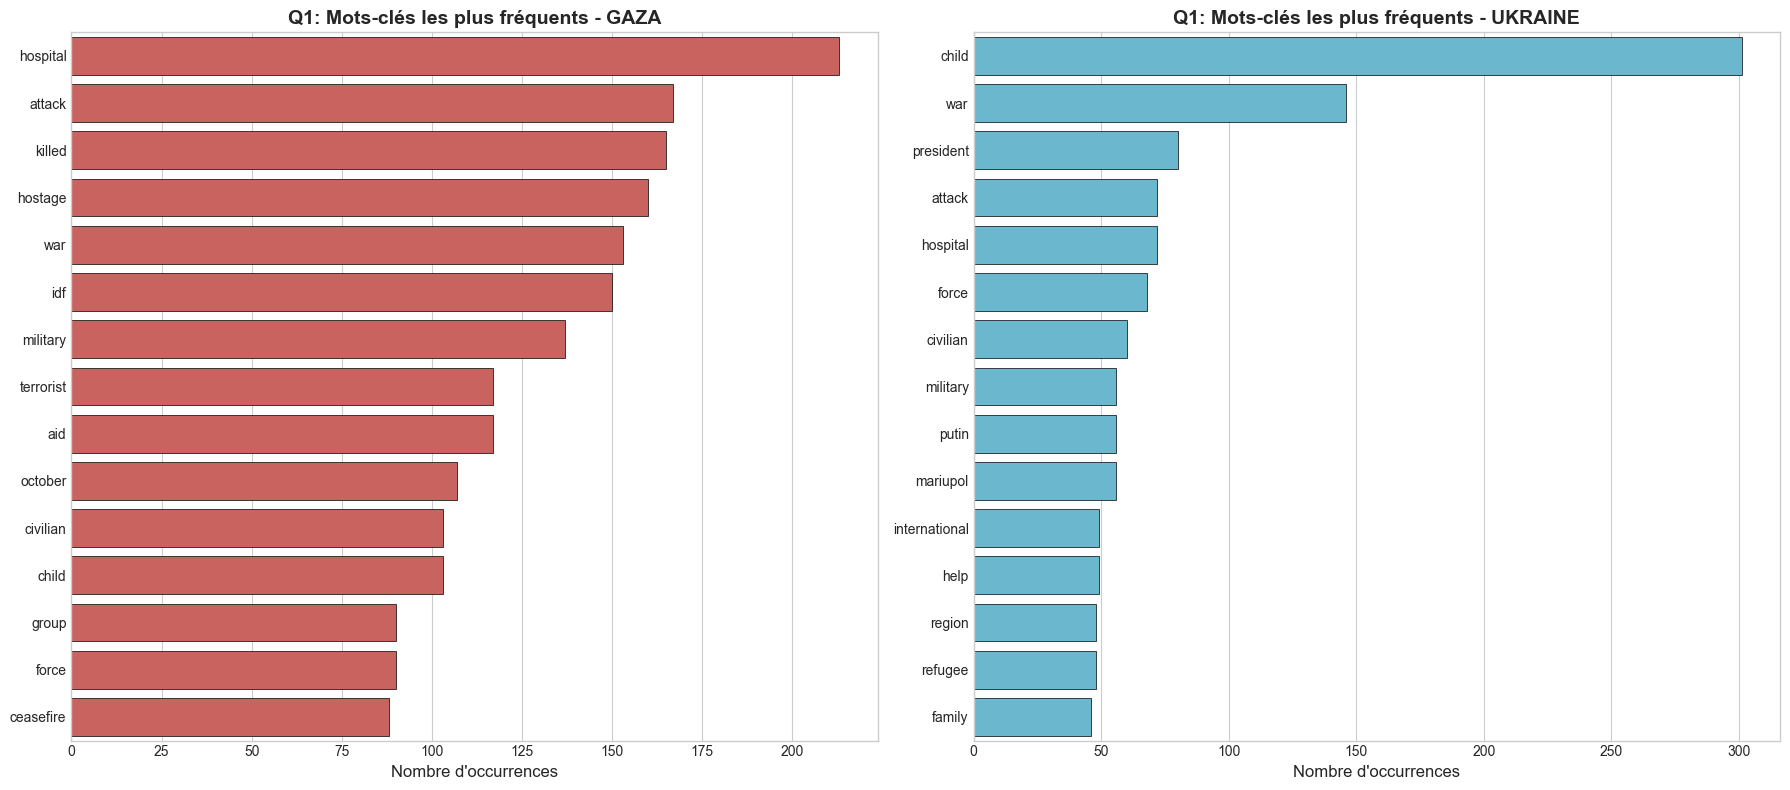

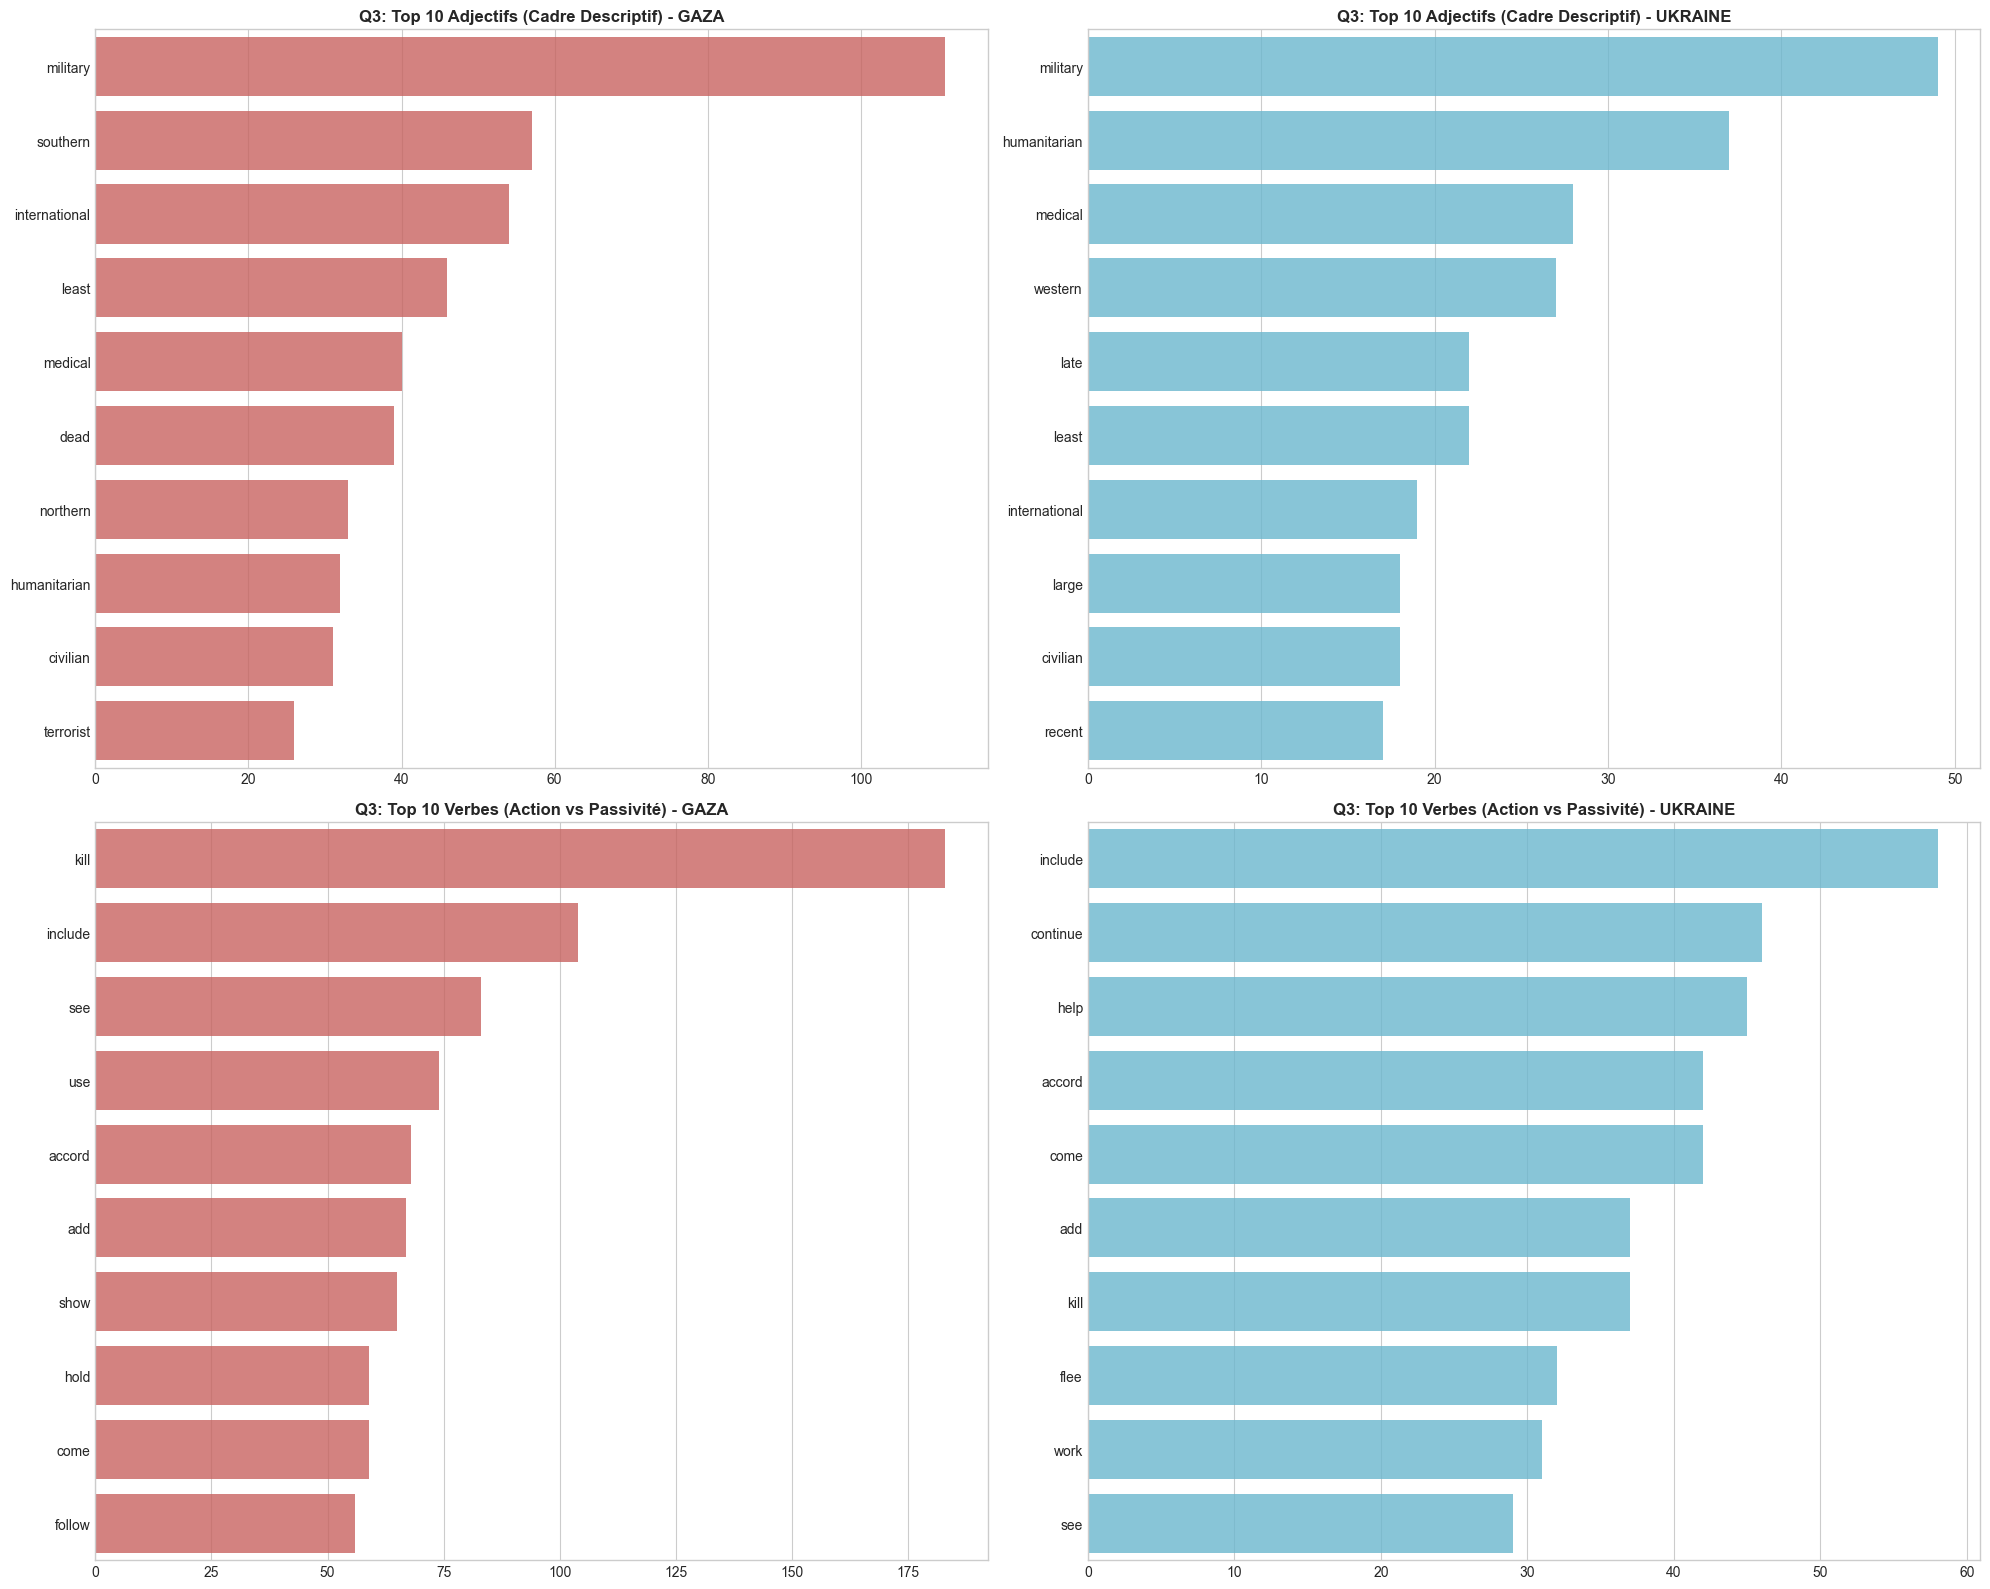

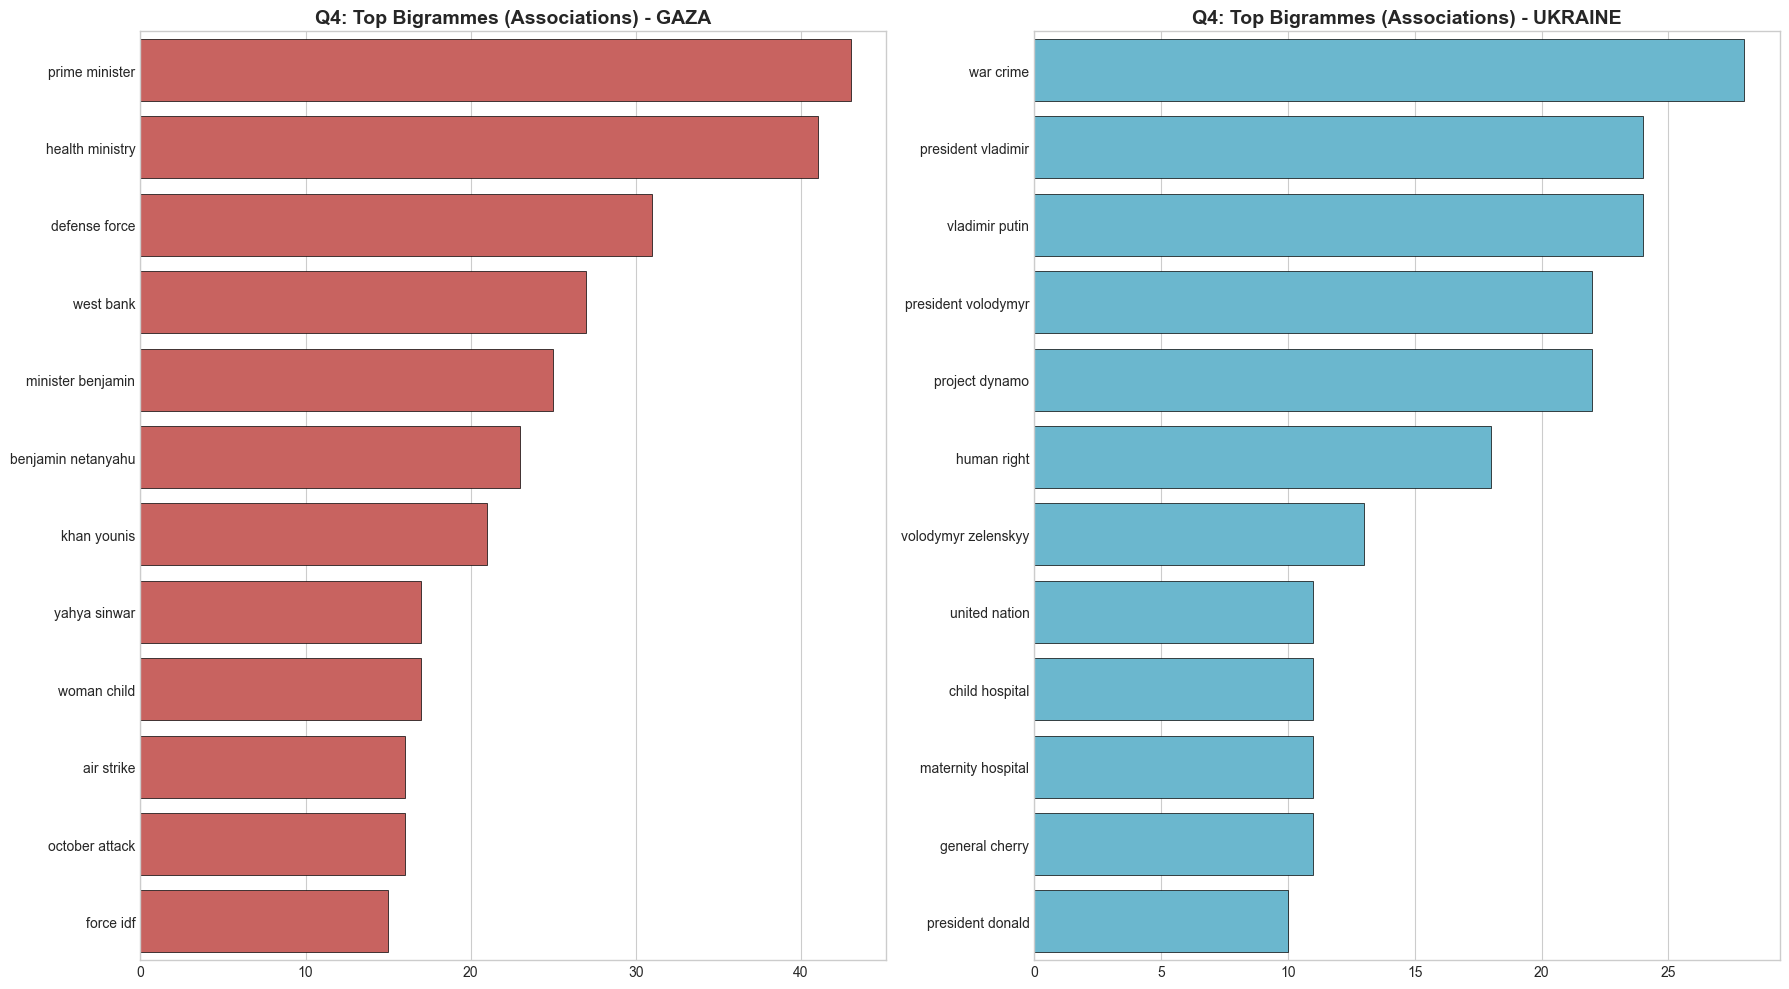

In [19]:
# =================================================================
# PROJET NLP HPC : GÉNÉRATEUR DE RAPPORTS VISUELS (EXPERT MODE)
# =================================================================
# Auteur : Expert Data Science
# Objectif : Générer les preuves visuelles pour chaque question du prof
# =================================================================

import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk import ngrams
import nltk
import numpy as np

# Configuration Graphique Pro (Style Académique)
plt.style.use('seaborn-v0_8-whitegrid')
COLORS = {'GAZA': '#d9534f', 'UKRAINE': '#5bc0de'} # Rouge Urgence / Bleu Calme

# --- 1. CONFIGURATION DU FILTRE ---
def get_expert_stopwords():
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
        
    base_stops = set(stopwords.words('english'))
    reporting_verbs = {'say', 'said', 'told', 'tell', 'reported', 'report', 
                       'according', 'added', 'stated', 'noted', 'announced'}
    topic_entities = {'gaza', 'israel', 'israeli', 'hamas', 'palestine', 
                      'palestinian', 'ukraine', 'ukrainian', 'russia', 
                      'russian', 'kyiv', 'moscow', 'strip', 'state'}
    noise_words = {'also', 'one', 'two', 'year', 'new', 'would', 'could', 
                   'first', 'last', 'many', 'people', 'since', 'including', 
                   'country', 'part', 'official', 'city', 'day', 'time', 
                   'week', 'month', 'video', 'make', 'take'}
    
    return base_stops.union(reporting_verbs).union(topic_entities).union(noise_words)

# --- 2. CHARGEMENT DES DONNÉES ---
def charger_donnees(chemin):
    with open(chemin, 'r', encoding='utf-8') as f:
        data = json.load(f)
    expert_stops = get_expert_stopwords()
    
    content = {
        'lexical': [],
        'adjectifs': [],
        'verbes': []
    }
    
    for art in data:
        # Lexical (Mots pleins)
        content['lexical'].extend([w for w in art['lexical_view'] 
                                   if w not in expert_stops and len(w) > 2 and not w.isdigit()])
        # Grammaire
        for phrase in art['structural_view']:
            for token in phrase:
                mot = token['l']
                tag = token['t']
                if mot not in expert_stops and len(mot) > 2:
                    if tag.startswith('J'): content['adjectifs'].append(mot)
                    elif tag.startswith('V'): content['verbes'].append(mot)
    return content

# --- 3. FONCTIONS DE VISUALISATION PAR QUESTION ---

def plot_top_words(data_gaza, data_ukraine):
    """ QUESTION 1 & 2 : Termes récurrents & Asymétrie """
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    for ax, (label, data) in zip(axes, [('GAZA', data_gaza), ('UKRAINE', data_ukraine)]):
        counter = Counter(data['lexical']).most_common(15)
        words, counts = zip(*counter)
        
        sns.barplot(x=list(counts), y=list(words), ax=ax, color=COLORS[label], edgecolor='black')
        ax.set_title(f"Q1: Mots-clés les plus fréquents - {label}", fontsize=14, fontweight='bold')
        ax.set_xlabel("Nombre d'occurrences")
        
    plt.tight_layout()
    plt.savefig("Rapport_Q1_MotsCles.png")
    print("✅ Graphique Q1 généré : Rapport_Q1_MotsCles.png")

def plot_lexical_variations(data_gaza, data_ukraine):
    """ QUESTION 3 : Variations Lexicales (Adjectifs & Verbes) """
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # 1. Comparaison Adjectifs
    for i, (label, data) in enumerate([('GAZA', data_gaza), ('UKRAINE', data_ukraine)]):
        counter = Counter(data['adjectifs']).most_common(10)
        words, counts = zip(*counter)
        sns.barplot(x=list(counts), y=list(words), ax=axes[0, i], color=COLORS[label], alpha=0.8)
        axes[0, i].set_title(f"Q3: Top 10 Adjectifs (Cadre Descriptif) - {label}", fontsize=12, fontweight='bold')

    # 2. Comparaison Verbes
    for i, (label, data) in enumerate([('GAZA', data_gaza), ('UKRAINE', data_ukraine)]):
        counter = Counter(data['verbes']).most_common(10)
        words, counts = zip(*counter)
        sns.barplot(x=list(counts), y=list(words), ax=axes[1, i], color=COLORS[label], alpha=0.8)
        axes[1, i].set_title(f"Q3: Top 10 Verbes (Action vs Passivité) - {label}", fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig("Rapport_Q3_Variations.png")
    print("✅ Graphique Q3 généré : Rapport_Q3_Variations.png")

def plot_cooccurrences(data_gaza, data_ukraine):
    """ QUESTION 4 : Cooccurrences (Bigrammes) """
    fig, axes = plt.subplots(1, 2, figsize=(18, 10))
    
    for ax, (label, data) in zip(axes, [('GAZA', data_gaza), ('UKRAINE', data_ukraine)]):
        bigrams = list(ngrams(data['lexical'], 2))
        # Conversion tuple -> string pour l'affichage ("war crime")
        bigrams_str = [" ".join(bg) for bg in bigrams]
        
        counter = Counter(bigrams_str).most_common(12)
        words, counts = zip(*counter)
        
        sns.barplot(x=list(counts), y=list(words), ax=ax, color=COLORS[label], edgecolor='black')
        ax.set_title(f"Q4: Top Bigrammes (Associations) - {label}", fontsize=14, fontweight='bold')
        
    plt.tight_layout()
    plt.savefig("Rapport_Q4_Cooccurrences.png")
    print("✅ Graphique Q4 généré : Rapport_Q4_Cooccurrences.png")

def afficher_trigrammes_texte(data_gaza, data_ukraine):
    """ QUESTION 4 (Suite) : Trigrammes (Concepts Complexes) """
    print("\n" + "="*50)
    print("Q4 : ANALYSE DES TRIGRAMMES (CONCEPTS COMPLEXES)")
    print("="*50)
    
    for label, data in [('GAZA', data_gaza), ('UKRAINE', data_ukraine)]:
        trigrams = list(ngrams(data['lexical'], 3))
        top_tri = Counter(trigrams).most_common(10)
        print(f"\n--- {label} ---")
        for trigram, count in top_tri:
            print(f"  {count} x : {' '.join(trigram)}")

# --- 4. EXÉCUTION ---
if __name__ == "__main__":
    print("Chargement des données prétraitées...")
    gaza = charger_donnees('corpus/corpus_gaza_pretraiter.json')
    ukraine = charger_donnees('corpus/corpus_ukraine_pretraiter.json')
    
    # GÉNÉRATION DES PREUVES
    plot_top_words(gaza, ukraine)          # Répond à Q1 et Q2
    plot_lexical_variations(gaza, ukraine) # Répond à Q3
    plot_cooccurrences(gaza, ukraine)      # Répond à Q4
    afficher_trigrammes_texte(gaza, ukraine) # Complément Q4

⏳ Chargement et nettoyage expert...
✅ Image 1 générée : Top Mots
✅ Image 2 générée : Variations Lexicales
✅ Image 3 générée : Cooccurrences

🎉 Terminé ! Les 3 images sont prêtes pour ton rapport.


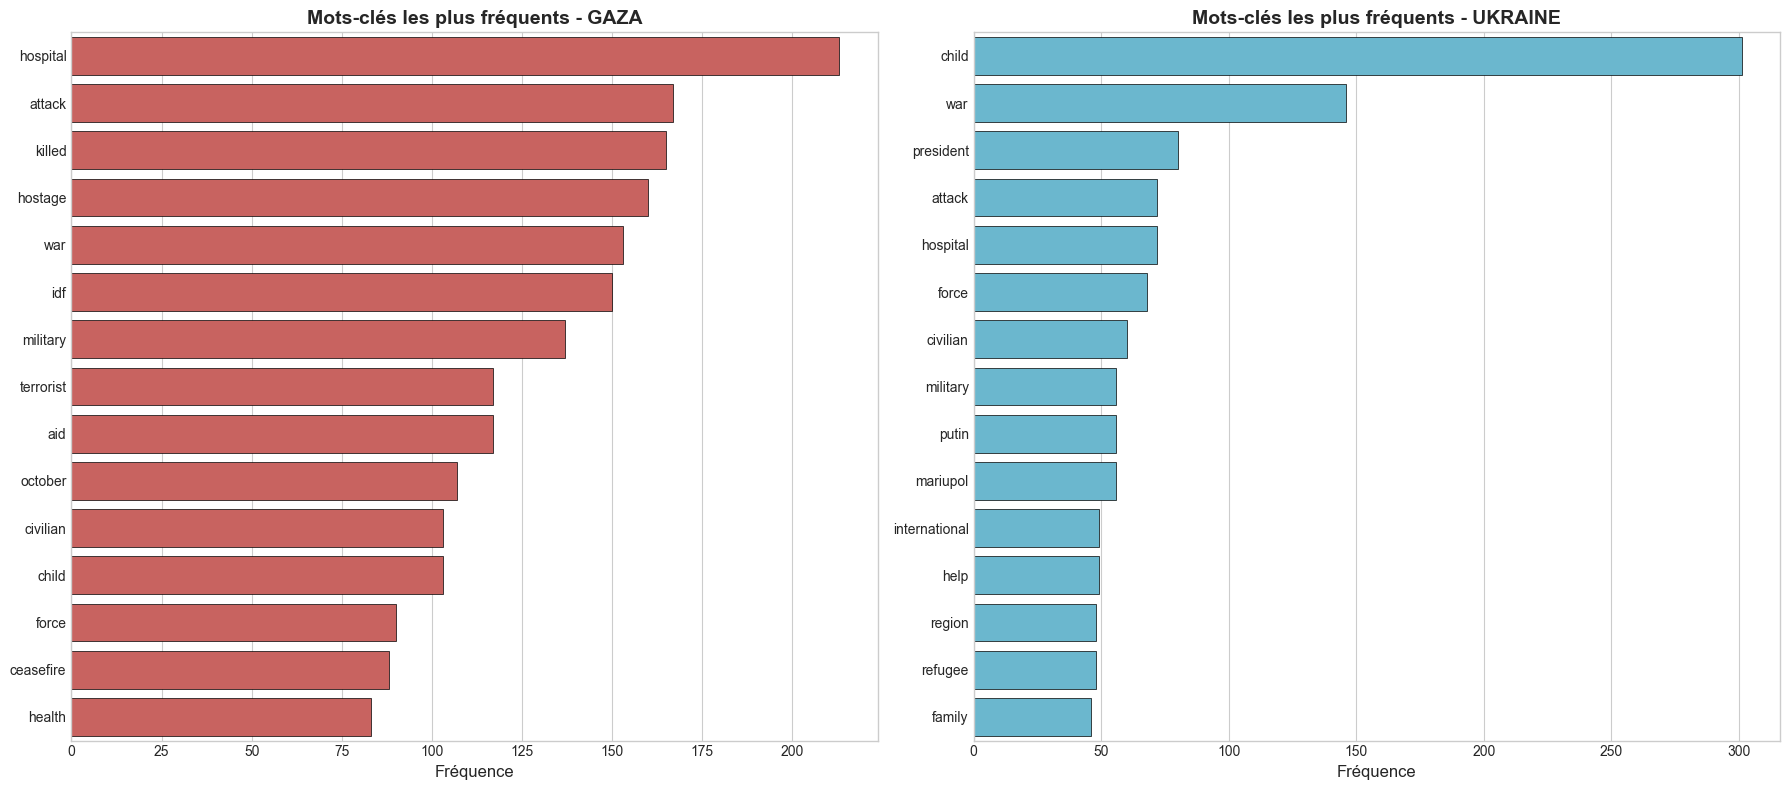

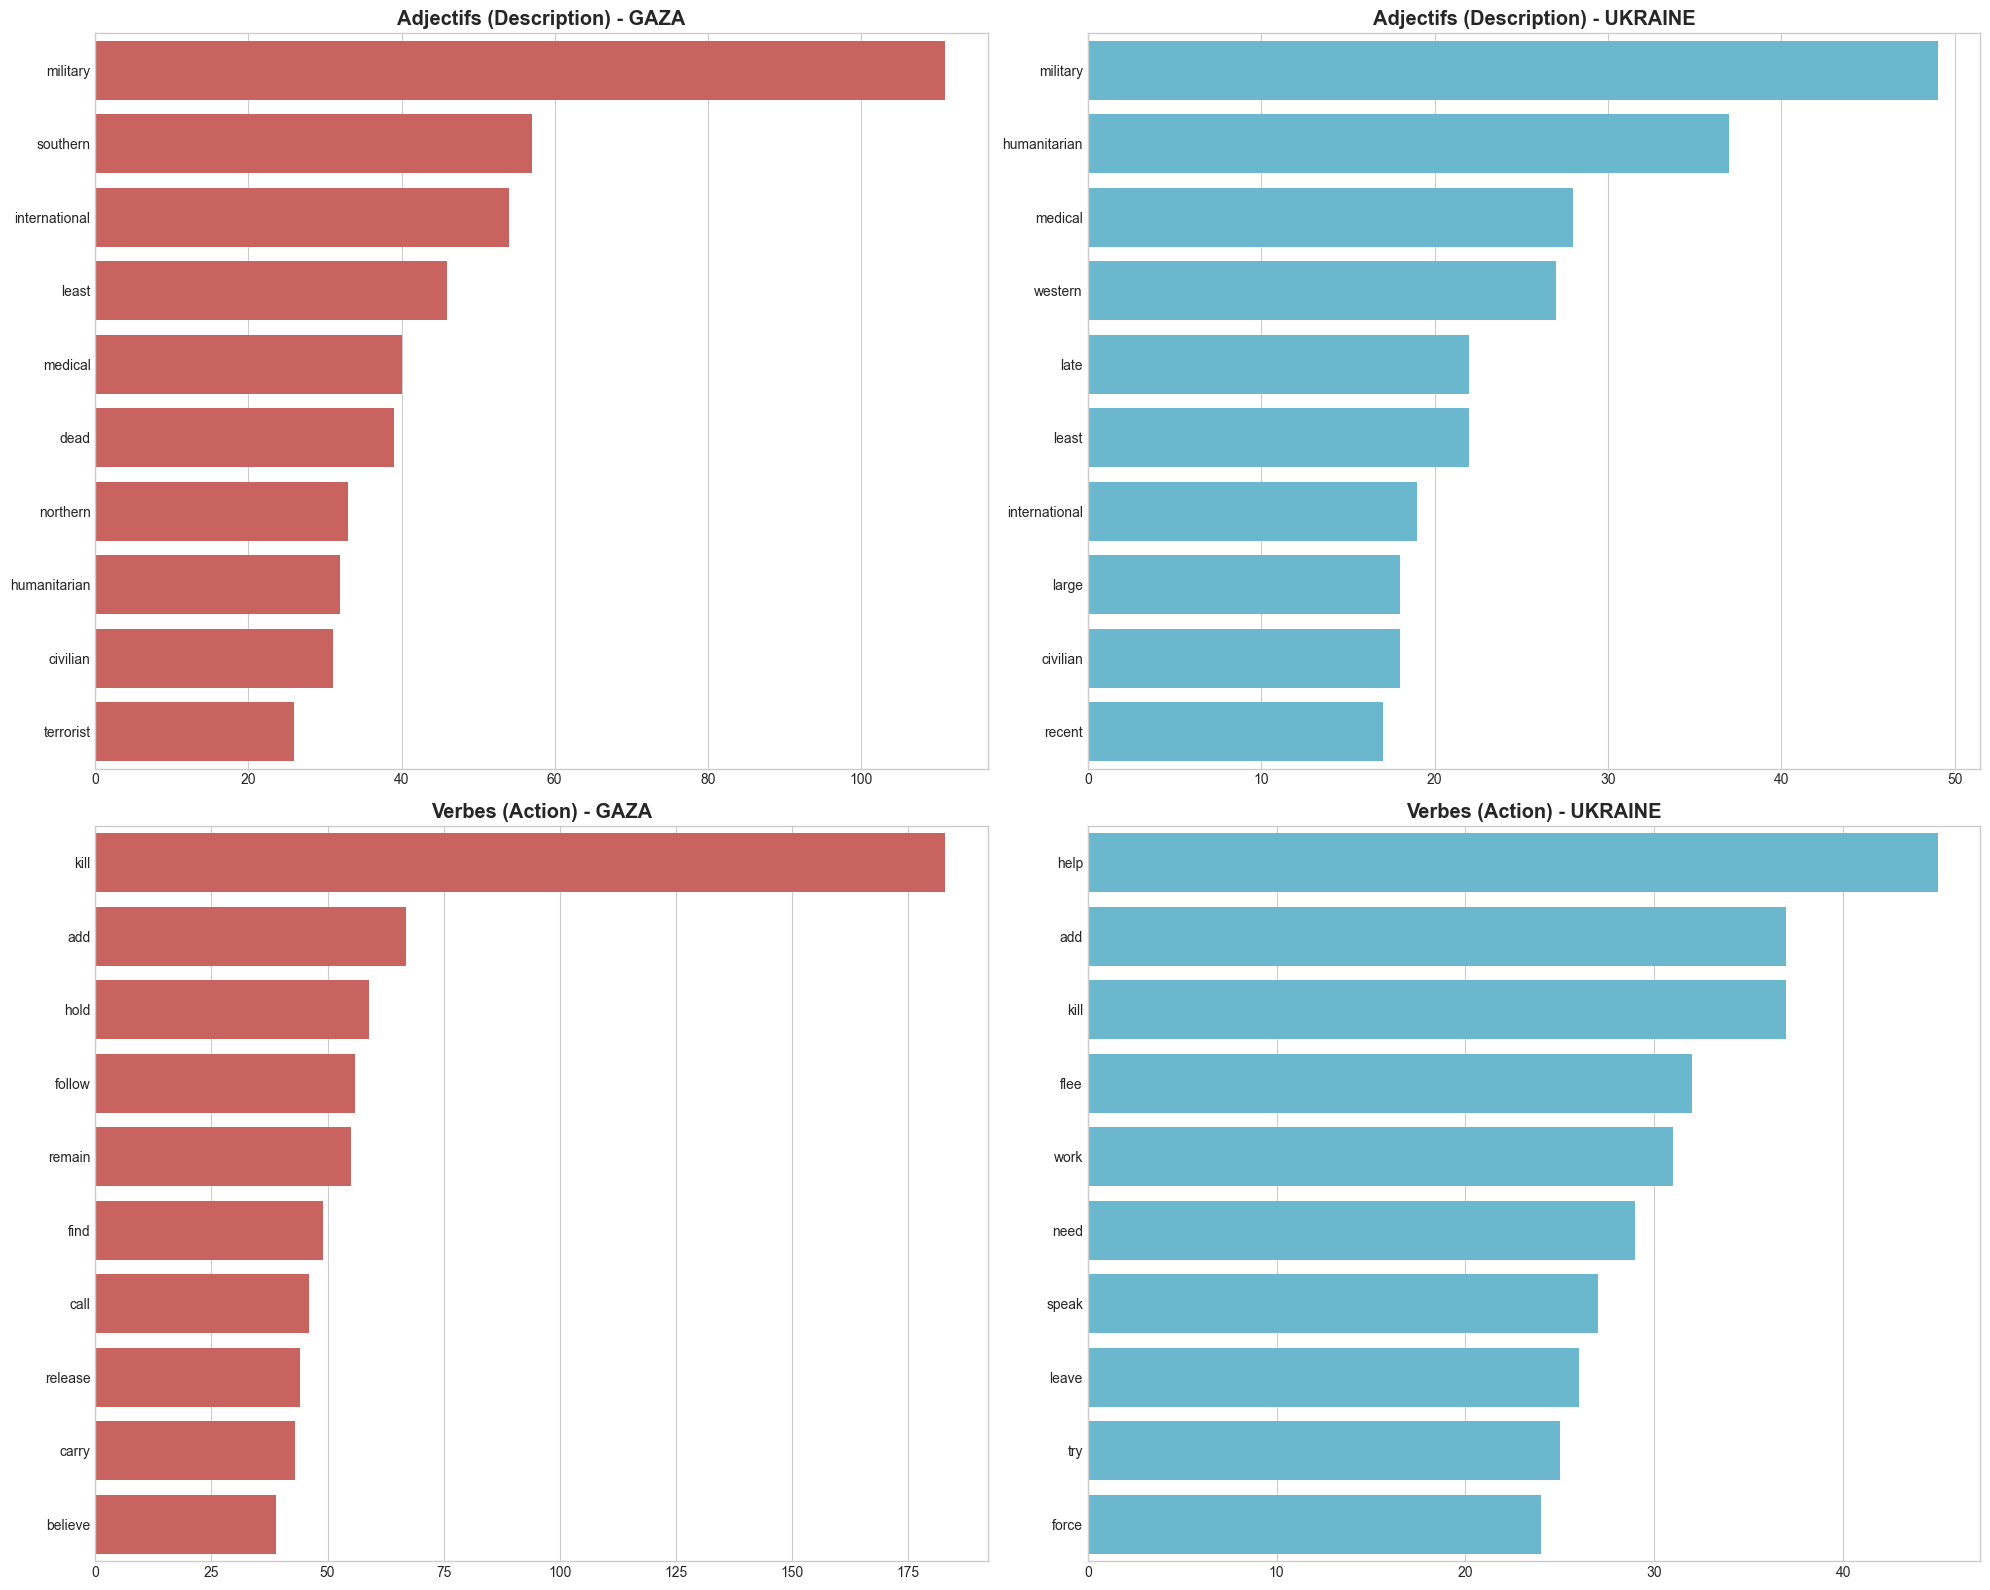

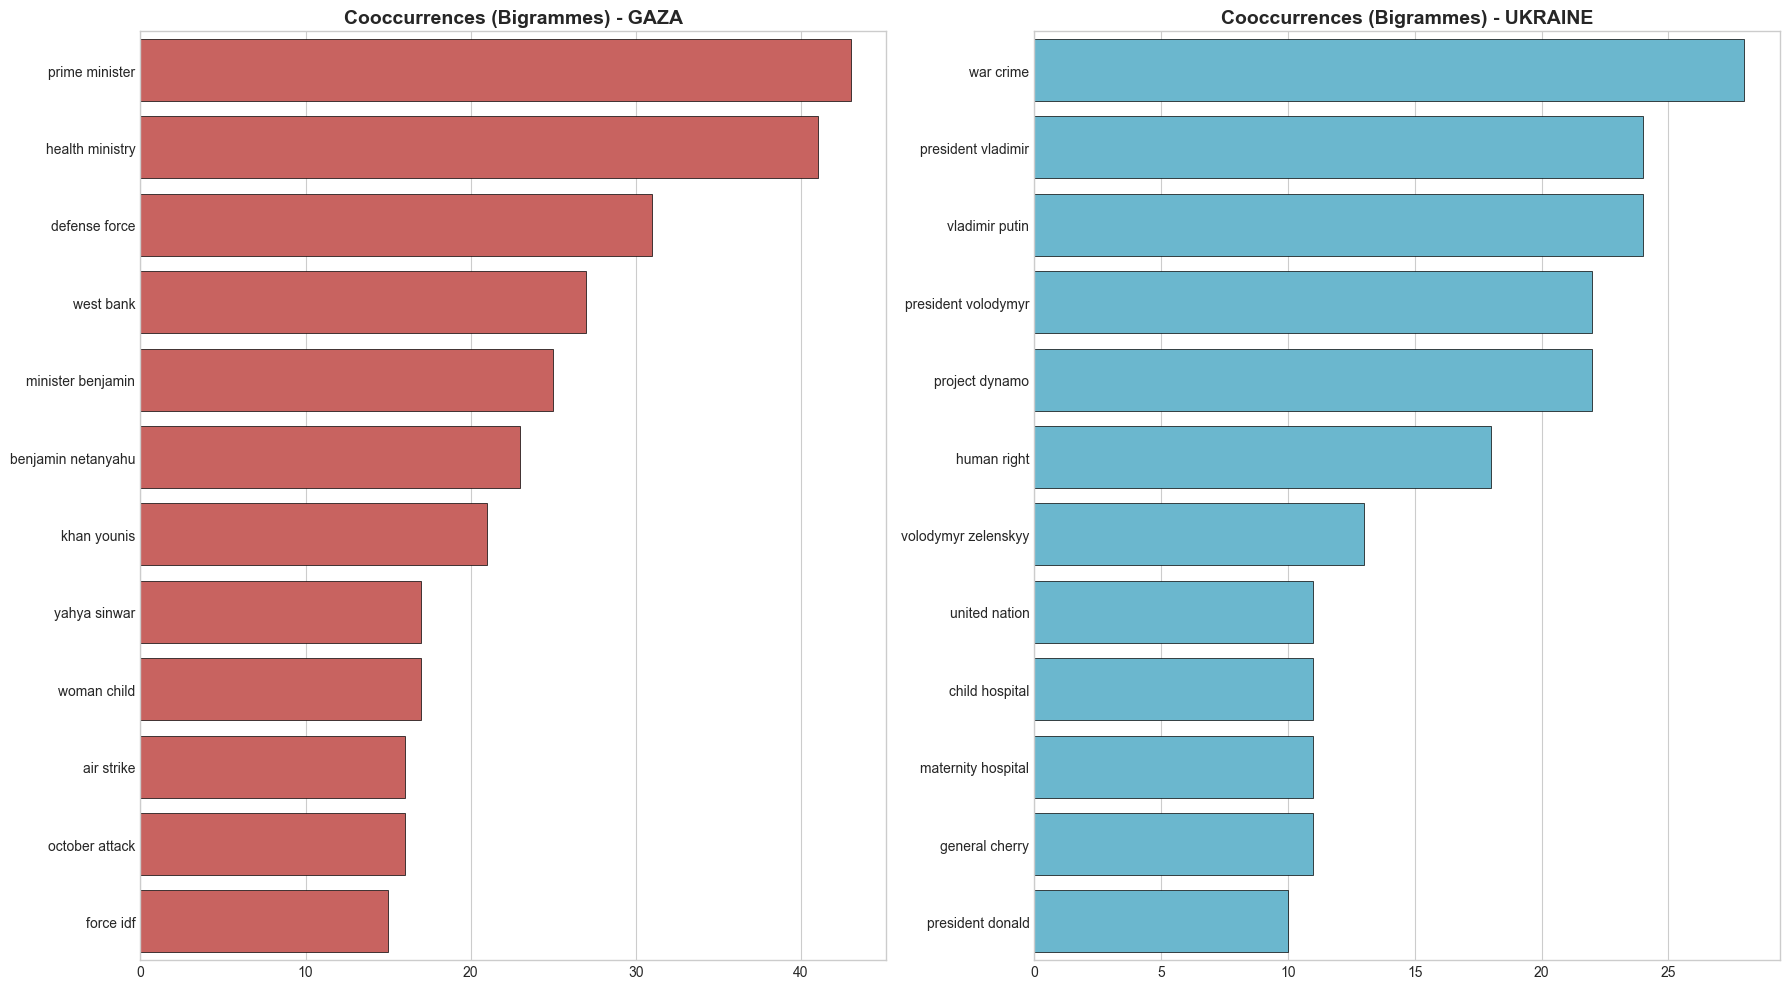

In [ ]:
# =================================================================
# PROJET NLP HPC : ANALYSE ET VISUALISATION FINALE (EXPERT MODE)
# =================================================================

import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk import ngrams
import nltk
import numpy as np

# Configuration Graphique
plt.style.use('seaborn-v0_8-whitegrid')
COLORS = {'GAZA': '#d9534f', 'UKRAINE': '#5bc0de'}

# --- 1. CONFIGURATION DU FILTRE (NETTOYAGE AVANCÉ) ---
def get_expert_stopwords():
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
        
    base_stops = set(stopwords.words('english'))
    
    # A. Verbes de reportage et verbes "mous" (BRUIT À SUPPRIMER)
    # C'est ici qu'on corrige ton problème des verbes
    verbs_to_exclude = {
        'say', 'said', 'told', 'tell', 'reported', 'report', 'according', 
        'added', 'stated', 'noted', 'announced', 'include', 'including', 
        'accord', 'make', 'take', 'come', 'go', 'see', 'use', 'show', 
        'expect', 'continue', 'know', 'think', 'get', 'become'
    }
    
    # B. Entités Thématiques (On les enlève pour voir les thèmes cachés)
    topic_entities = {'gaza', 'israel', 'israeli', 'hamas', 'palestine', 
                      'palestinian', 'ukraine', 'ukrainian', 'russia', 
                      'russian', 'kyiv', 'moscow', 'strip', 'state'}
    
    # C. Mots vides statistiques
    noise_words = {'also', 'one', 'two', 'year', 'new', 'would', 'could', 
                   'first', 'last', 'many', 'people', 'since', 'country', 
                   'part', 'official', 'city', 'day', 'time', 'week', 
                   'month', 'video', 'even', 'way', 'thing', 'group'}
    
    return base_stops.union(verbs_to_exclude).union(topic_entities).union(noise_words)

# --- 2. CHARGEMENT DES DONNÉES ---
def charger_donnees(chemin):
    with open(chemin, 'r', encoding='utf-8') as f:
        data = json.load(f)
    expert_stops = get_expert_stopwords()
    
    content = {
        'lexical': [],
        'adjectifs': [],
        'verbes': []
    }
    
    for art in data:
        # Lexical (Mots pleins pour WordCloud et Top Mots)
        # On garde 'group' ou 'force' ici car ils sont importants pour les noms
        mots_lexicaux = [w for w in art['lexical_view'] 
                         if w not in expert_stops and len(w) > 2 and not w.isdigit()]
        content['lexical'].extend(mots_lexicaux)
        
        # Grammaire (Adjectifs et Verbes)
        for phrase in art['structural_view']:
            for token in phrase:
                mot = token['l']
                tag = token['t']
                # Filtrage strict
                if mot not in expert_stops and len(mot) > 2:
                    if tag.startswith('J'): # Adjectif
                        content['adjectifs'].append(mot)
                    elif tag.startswith('V'): # Verbe
                        content['verbes'].append(mot)
    return content

# --- 3. FONCTIONS DE VISUALISATION (AUTOMATISÉES) ---

def plot_top_words(data_gaza, data_ukraine):
    """ QUESTION 1 : Top Mots-clés """
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    for ax, (label, data) in zip(axes, [('GAZA', data_gaza), ('UKRAINE', data_ukraine)]):
        counter = Counter(data['lexical']).most_common(15)
        words, counts = zip(*counter)
        sns.barplot(x=list(counts), y=list(words), ax=ax, color=COLORS[label], edgecolor='black')
        ax.set_title(f"Mots-clés les plus fréquents - {label}", fontsize=14, fontweight='bold')
        ax.set_xlabel("Fréquence")
        
    plt.tight_layout()
    plt.savefig("Image_1_Top_Mots.png")
    print("✅ Image 1 générée : Top Mots")

def plot_verbs_adjectives(data_gaza, data_ukraine):
    """ QUESTION 3 : Variations Lexicales (Adjectifs & Verbes) """
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Adjectifs
    for i, (label, data) in enumerate([('GAZA', data_gaza), ('UKRAINE', data_ukraine)]):
        counter = Counter(data['adjectifs']).most_common(10)
        words, counts = zip(*counter)
        sns.barplot(x=list(counts), y=list(words), ax=axes[0, i], color=COLORS[label])
        axes[0, i].set_title(f"Adjectifs (Description) - {label}", fontweight='bold')

    # Verbes
    for i, (label, data) in enumerate([('GAZA', data_gaza), ('UKRAINE', data_ukraine)]):
        counter = Counter(data['verbes']).most_common(10)
        words, counts = zip(*counter)
        sns.barplot(x=list(counts), y=list(words), ax=axes[1, i], color=COLORS[label])
        axes[1, i].set_title(f"Verbes (Action) - {label}", fontweight='bold')

    plt.tight_layout()
    plt.savefig("Image_2_Variations_Lexicales.png")
    print("✅ Image 2 générée : Variations Lexicales")

def plot_ngrams(data_gaza, data_ukraine):
    """ QUESTION 4 : Cooccurrences (Bigrammes) """
    fig, axes = plt.subplots(1, 2, figsize=(18, 10))
    
    for ax, (label, data) in zip(axes, [('GAZA', data_gaza), ('UKRAINE', data_ukraine)]):
        bigrams = list(ngrams(data['lexical'], 2))
        bigrams_str = [" ".join(bg) for bg in bigrams]
        
        counter = Counter(bigrams_str).most_common(12)
        words, counts = zip(*counter)
        
        sns.barplot(x=list(counts), y=list(words), ax=ax, color=COLORS[label], edgecolor='black')
        ax.set_title(f"Cooccurrences (Bigrammes) - {label}", fontsize=14, fontweight='bold')
        
    plt.tight_layout()
    plt.savefig("Image_3_Cooccurrences.png")
    print("✅ Image 3 générée : Cooccurrences")

# --- 4. EXÉCUTION ---
if __name__ == "__main__":
    print("⏳ Chargement et nettoyage expert...")
    gaza = charger_donnees('corpus/corpus_gaza_pretraiter.json')
    ukraine = charger_donnees('corpus/corpus_ukraine_pretraiter.json')
    
    # Génération des images pour le rapport
    plot_top_words(gaza, ukraine)
    plot_verbs_adjectives(gaza, ukraine)
    plot_ngrams(gaza, ukraine)

    print("\n Terminé ! Les 3 images sont prêtes pour le rapport.")

⏳ Chargement...

📢 QUESTION 1 : IDENTIFICATION DES TERMES RÉCURRENTS (TOP 20)

🔹 TOP 20 MOTS - GAZA :
   1. hospital        (213)
   2. attack          (167)
   3. killed          (165)
   4. hostage         (160)
   5. war             (153)
   6. idf             (150)
   7. military        (137)
   8. strip           (118)
   9. terrorist       (117)
   10. aid             (117)
   11. october         (107)
   12. civilian        (103)
   13. child           (103)
   14. force           (90)
   15. ceasefire       (88)
   16. health          (83)
   17. body            (73)
   18. food            (72)
   19. strike          (71)
   20. tunnel          (66)

🔹 TOP 20 MOTS - UKRAINE :
   1. child           (301)
   2. war             (146)
   3. president       (80)
   4. attack          (72)
   5. hospital        (72)
   6. force           (68)
   7. civilian        (60)
   8. military        (56)
   9. putin           (56)
   10. mariupol        (56)
   11. international   (49)
   12.

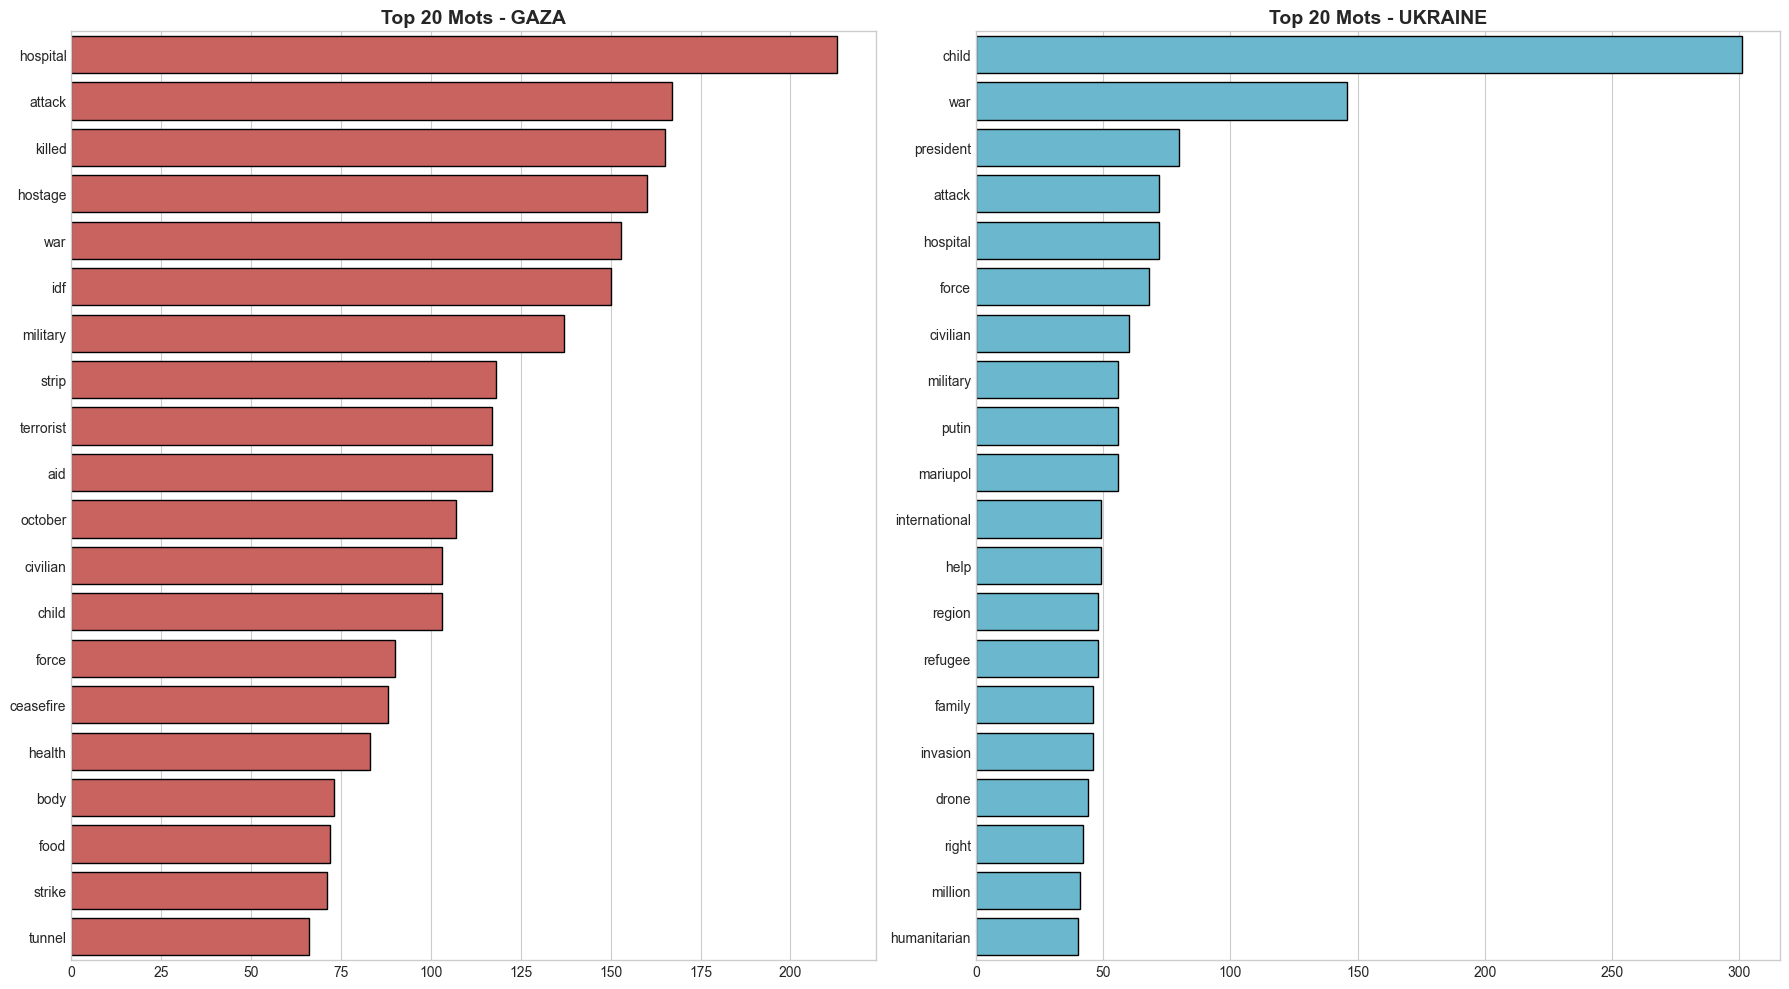

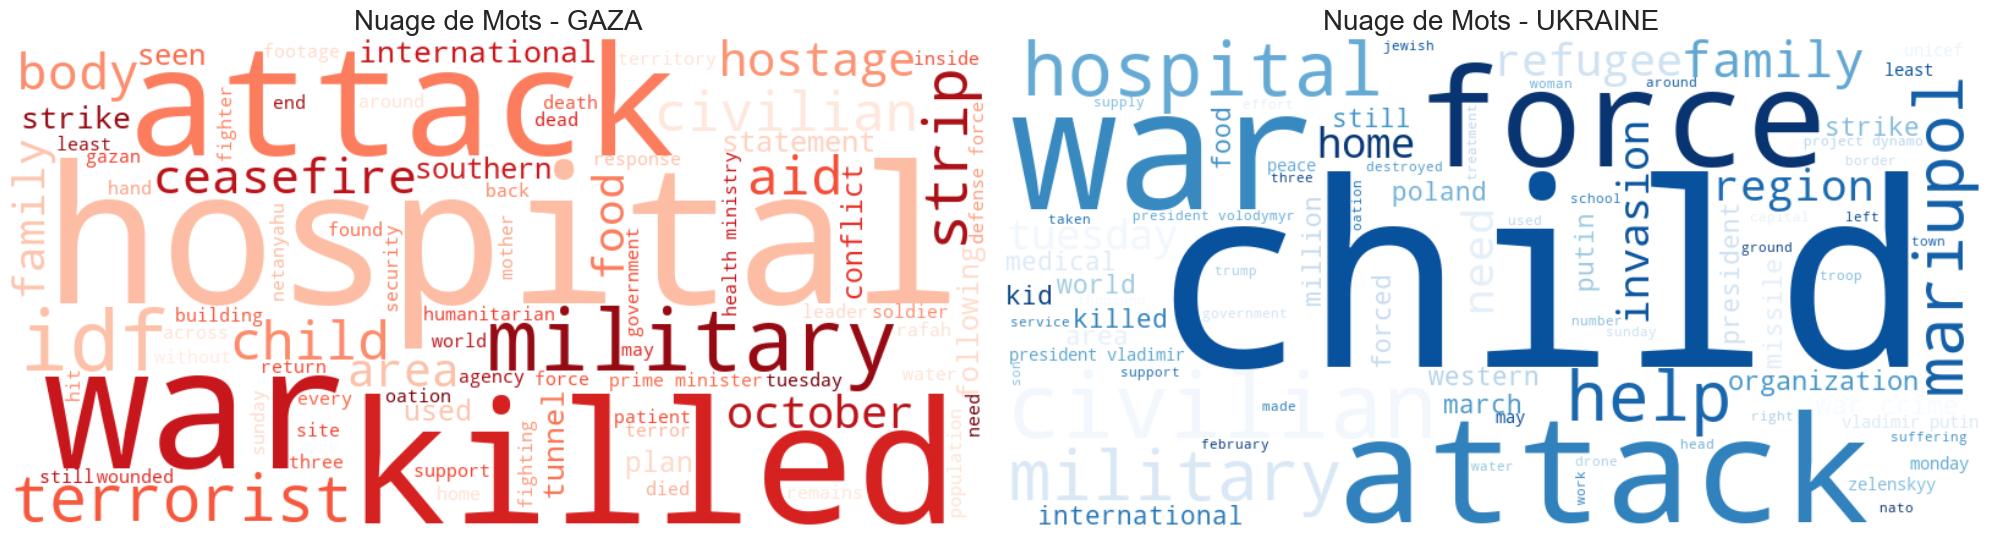

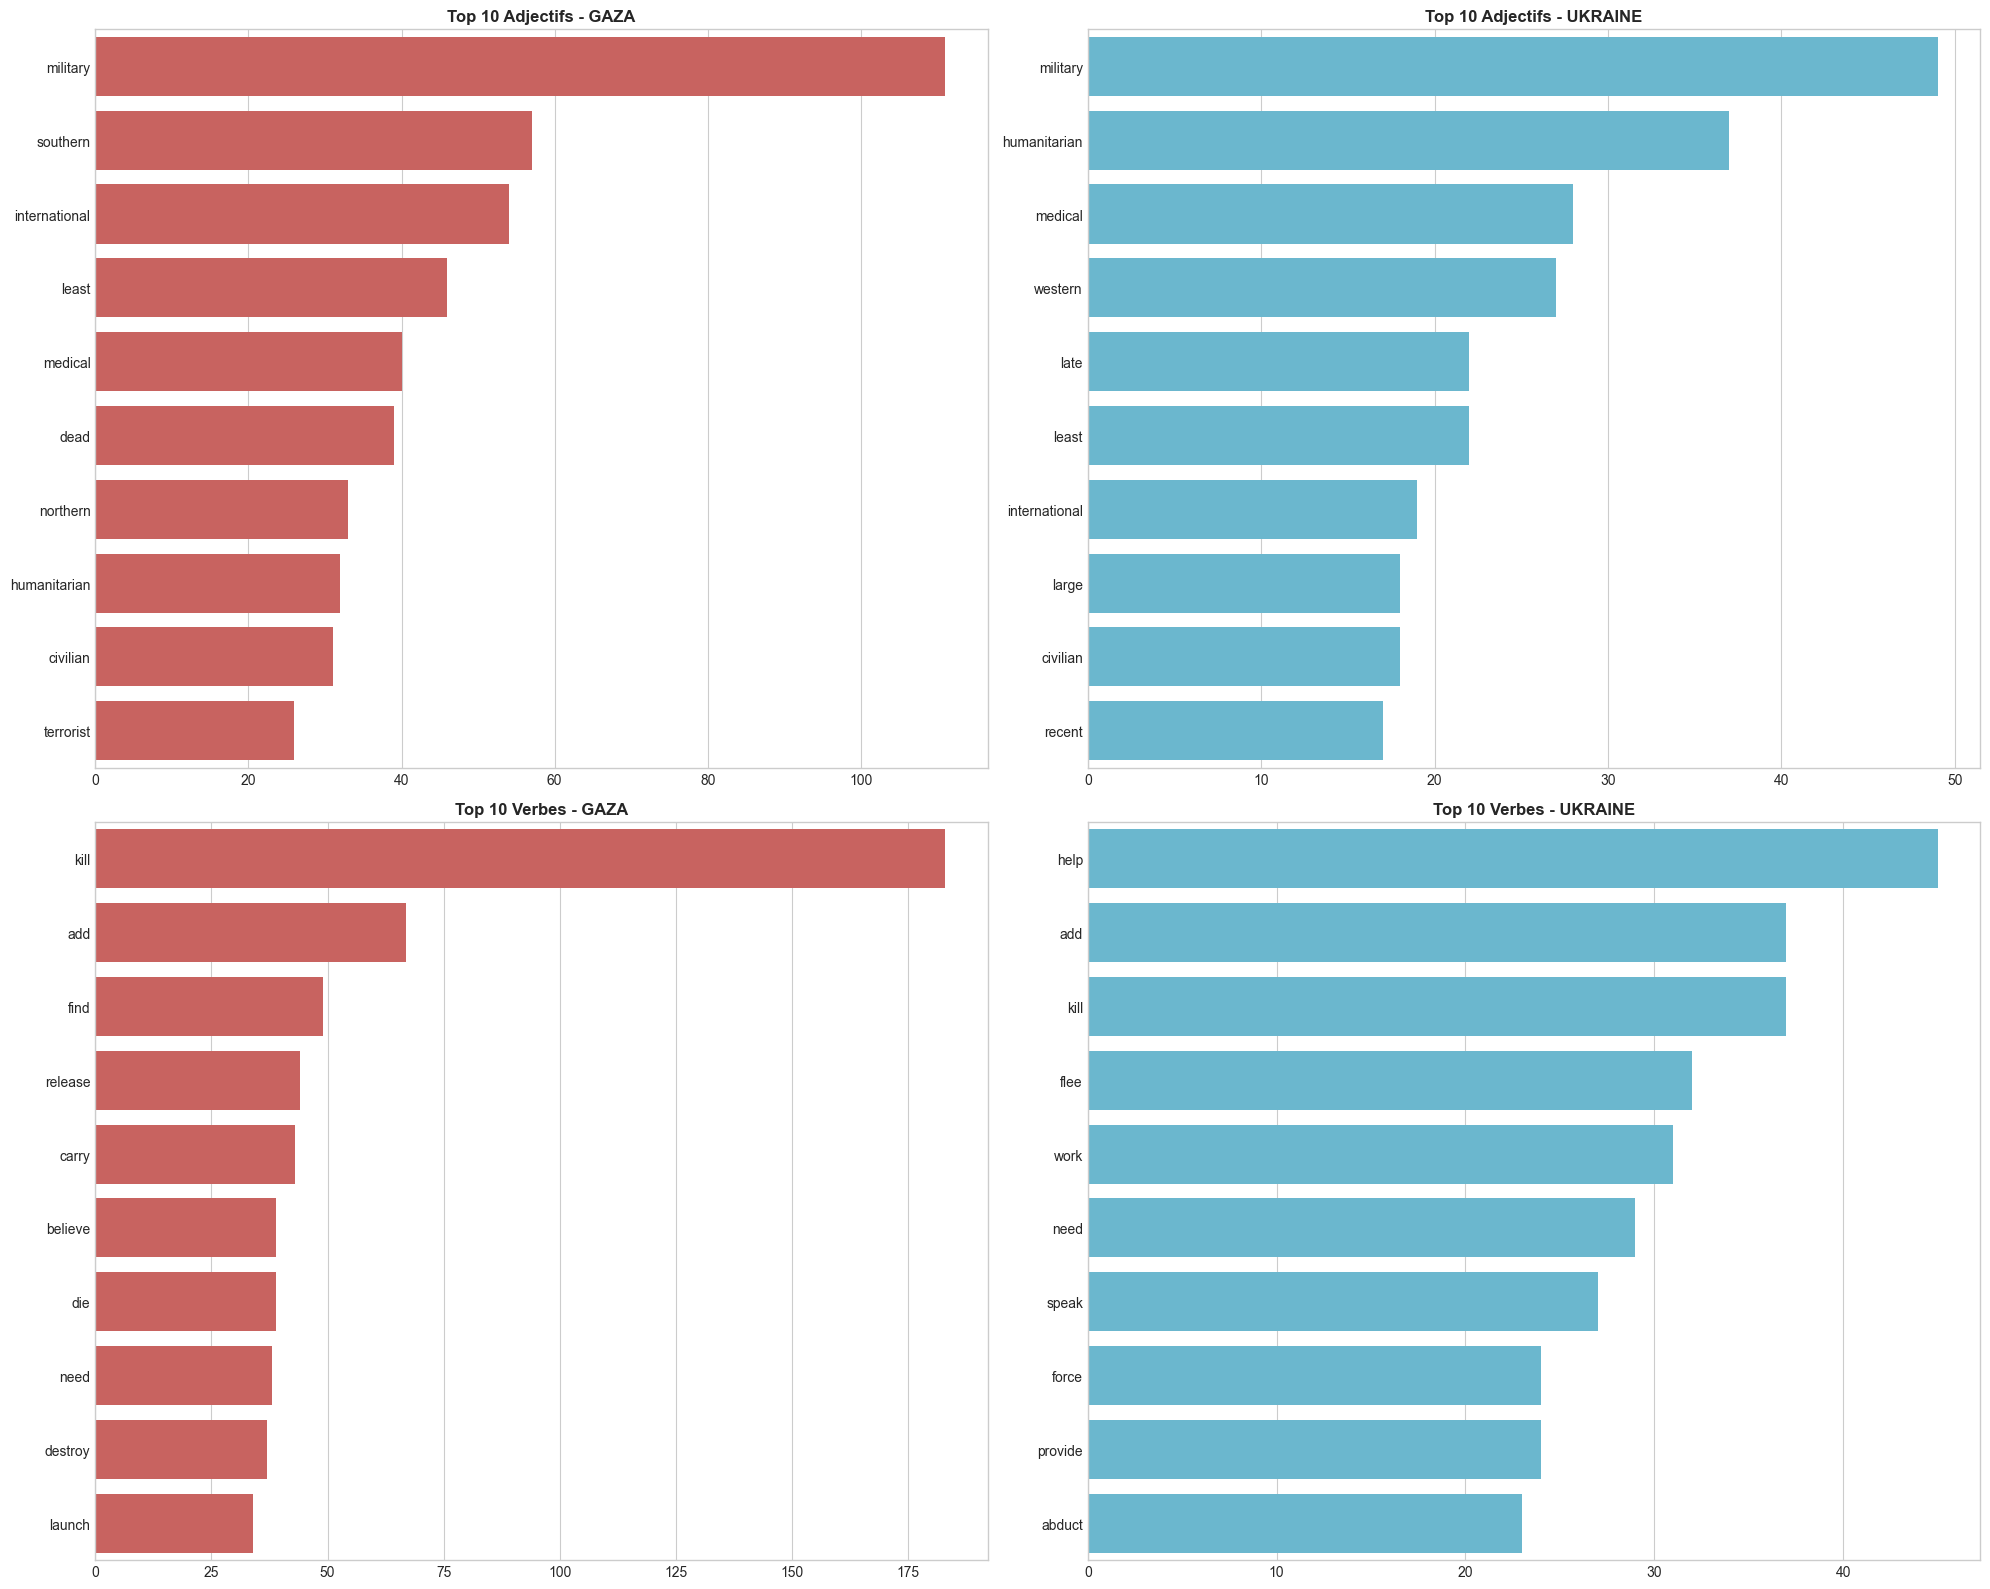

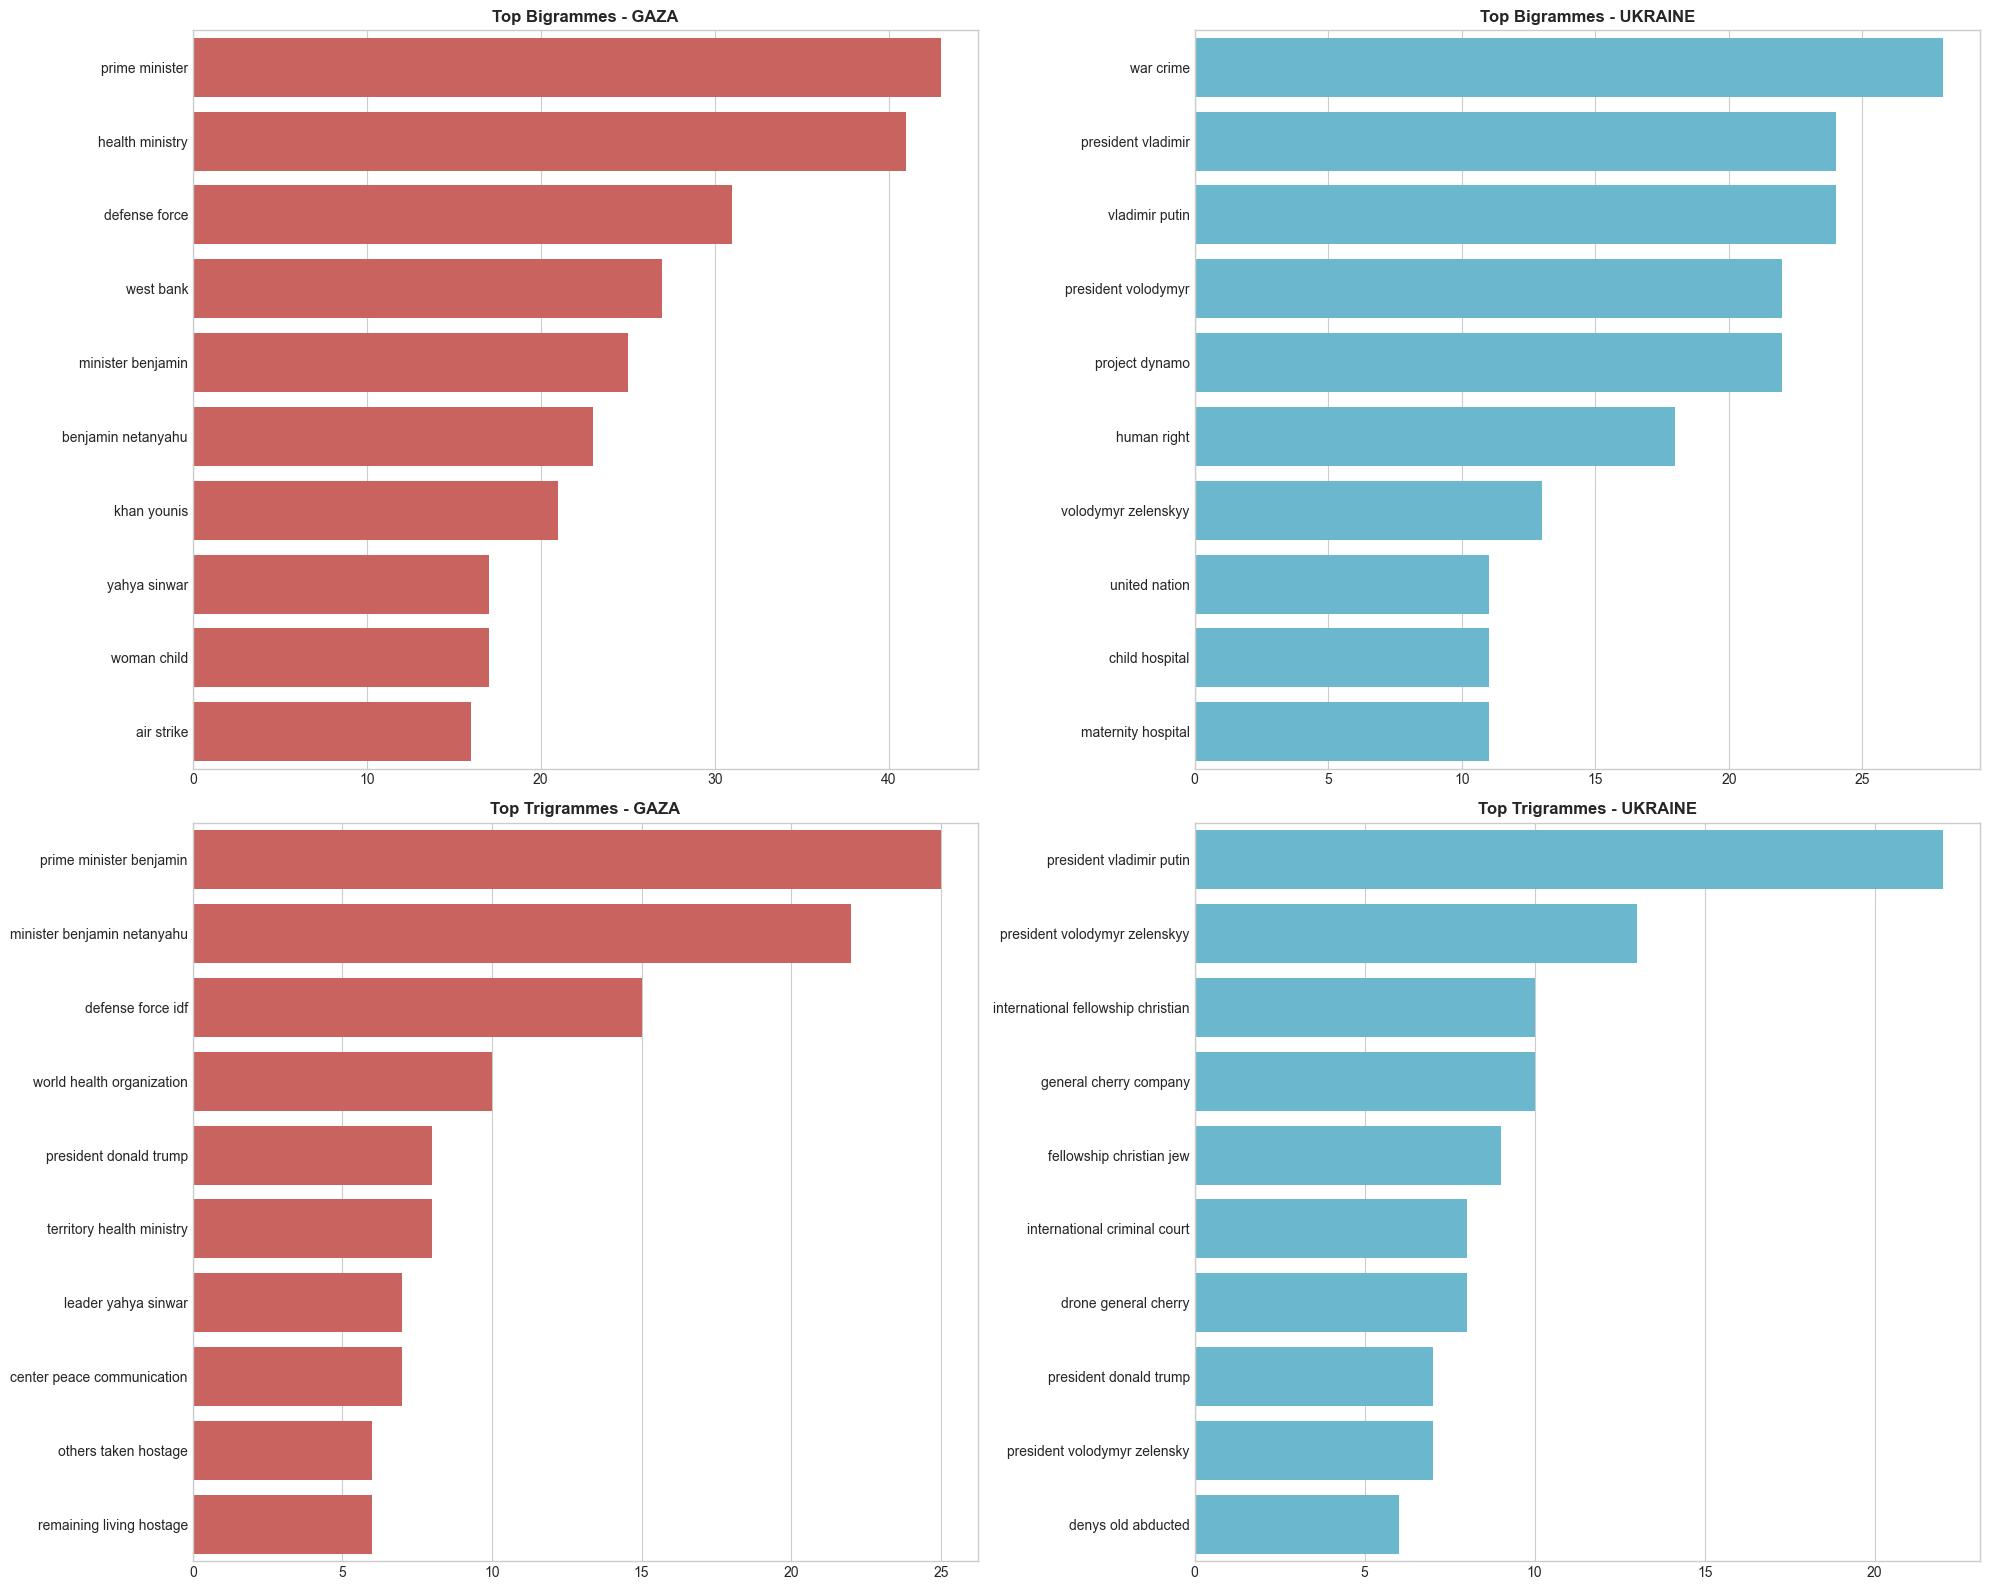

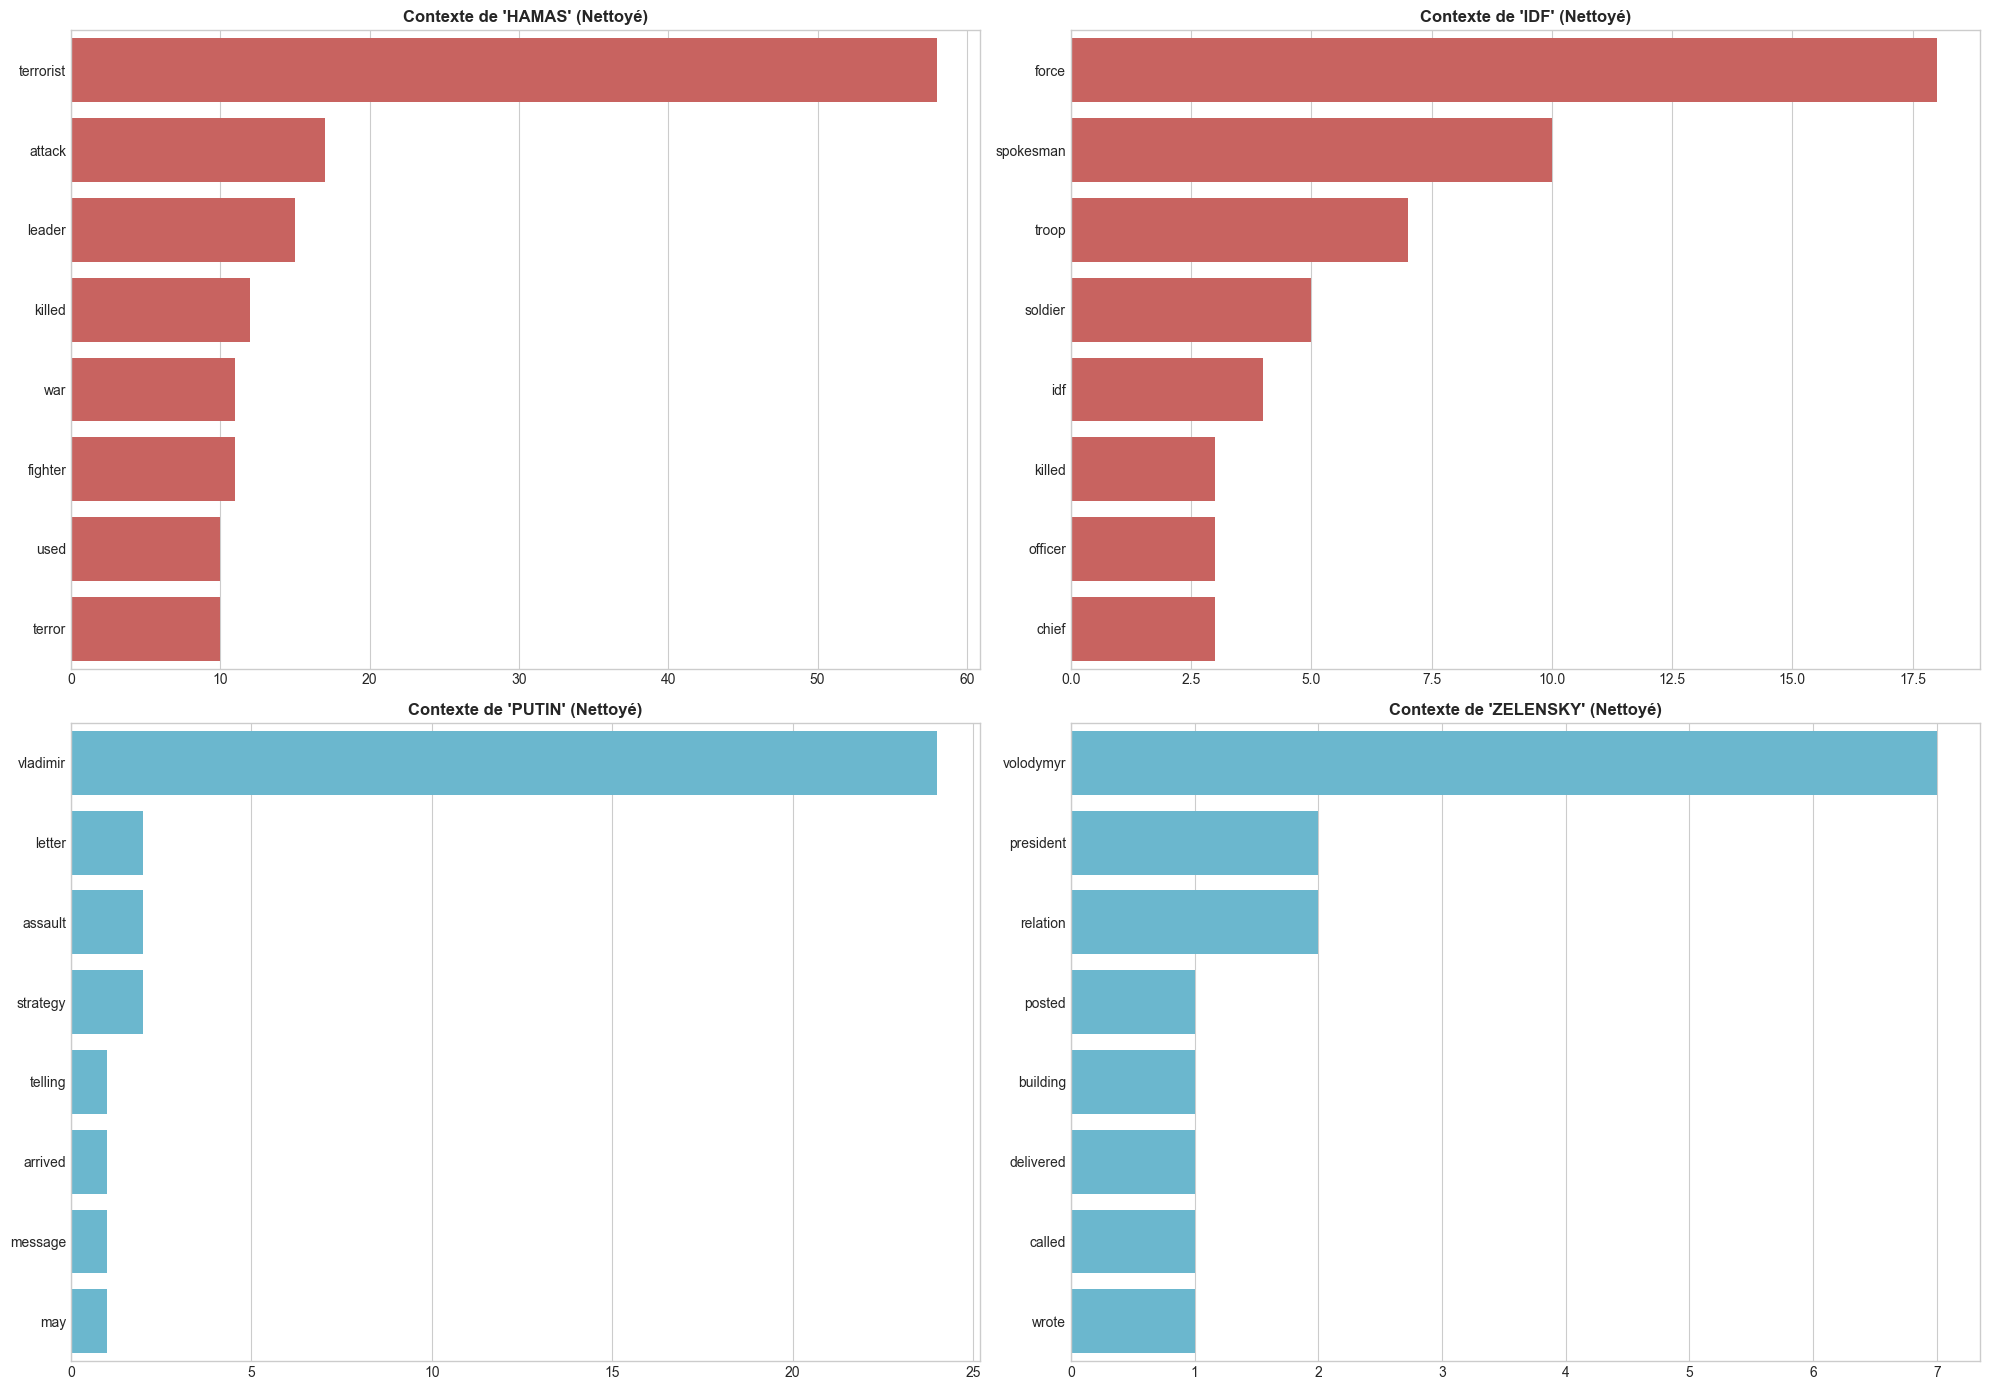

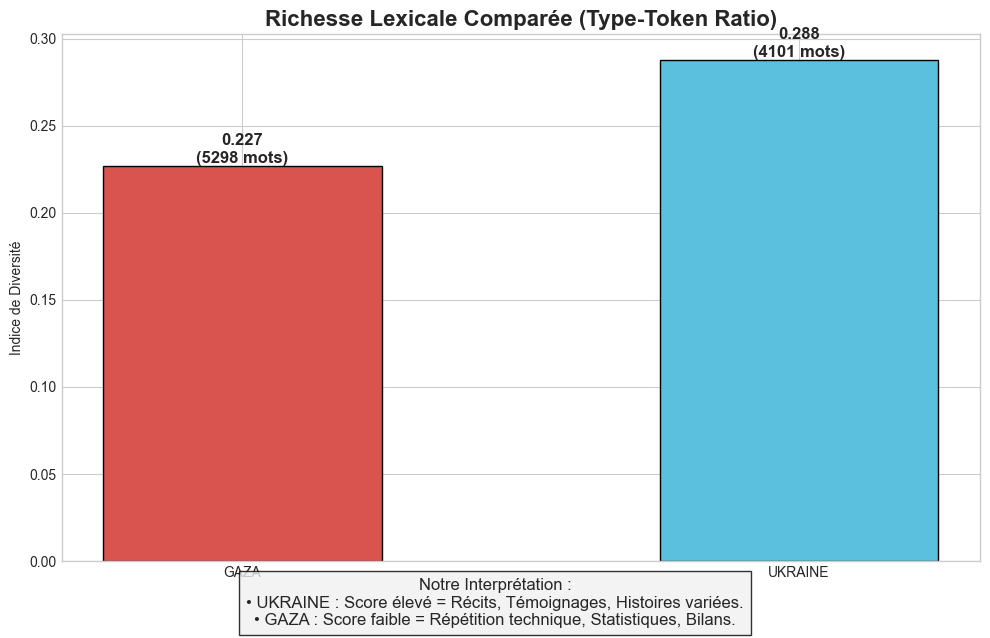

In [ ]:
# =================================================================
# PROJET NLP HPC : ANALYSE COMPLETE & VISUALISATION (FINAL PRINT)
# =================================================================
# Inclus : Top 20, WordClouds, Verbes/Adj, N-Grams, Acteurs, Richesse
# + AFFICHAGE TEXTUEL DES RÉSULTATS DANS LA CONSOLE
# =================================================================

import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk import ngrams
import nltk
import numpy as np
import os

# Création du dossier images
if not os.path.exists('images'):
    os.makedirs('images')

# Configuration Graphique
plt.style.use('seaborn-v0_8-whitegrid')
COLORS = {'GAZA': '#d9534f', 'UKRAINE': '#5bc0de'}

# --- 1. CONFIGURATION DU FILTRE ---
def get_expert_stopwords():
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
        
    base_stops = set(stopwords.words('english'))
    
    # A. VERBES À BANNIR (Bruit fonctionnel)
    verbs_to_exclude = {
        'say', 'said', 'told', 'tell', 'reported', 'report', 'according', 
        'added', 'stated', 'noted', 'announced', 'ask', 'call', 'claim',
        'include', 'including', 'accord', 'make', 'take', 'come', 'go', 
        'see', 'use', 'show', 'expect', 'continue', 'know', 'think', 
        'get', 'become', 'allow', 'remain', 'leave', 'want', 'seem', 
        'begin', 'start', 'follow', 'hold', 'involve', 'create', 'appear',
        'help', 'try', 'bring', 'lead', 'set', 'run', 'live', 'stand'
    }
    # Exceptions (Verbes forts à garder)
    verbs_to_keep = {'kill', 'die', 'attack', 'destroy', 'suffer', 'defend', 'save', 'flee', 'help'}
    verbs_to_exclude = verbs_to_exclude - verbs_to_keep

    # B. Entités Thématiques (On garde IDF et STRIP pour les trigrammes)
    topic_entities = {'gaza', 'israel', 'israeli', 'hamas', 'palestine', 
                      'palestinian', 'ukraine', 'ukrainian', 'russia', 
                      'russian', 'kyiv', 'moscow', 'state'} 
    
    # C. Mots vides statistiques
    noise_words = {'also', 'one', 'two', 'year', 'new', 'would', 'could', 
                   'first', 'last', 'many', 'people', 'since', 'country', 
                   'part', 'official', 'city', 'day', 'time', 'week', 
                   'month', 'video', 'even', 'way', 'thing', 'group', 'u', 'us',
                   'image', 'photo', 'source'}
    
    return base_stops.union(verbs_to_exclude).union(topic_entities).union(noise_words)

# --- 2. FONCTION ACTEURS ---
def get_actor_context(tokens, actor_name):
    """ Trouve les voisins immédiats de l'acteur """
    bigrams = list(ngrams(tokens, 2))
    associated_words = []
    for w1, w2 in bigrams:
        if w1 == actor_name: associated_words.append(w2) 
        if w2 == actor_name: associated_words.append(w1) 
    return associated_words

# --- 3. CHARGEMENT ---
def charger_donnees(chemin):
    with open(chemin, 'r', encoding='utf-8') as f:
        data = json.load(f)
    expert_stops = get_expert_stopwords()
    
    content = {
        'lexical': [],
        'adjectifs': [],
        'verbes': [],
        'raw_tokens': [] 
    }
    
    for art in data:
        # Lexical (Nettoyé)
        mots_lexicaux = [w for w in art['lexical_view'] 
                         if w not in expert_stops and len(w) > 2 and not w.isdigit()]
        content['lexical'].extend(mots_lexicaux)
        
        # Raw Tokens (Pour acteurs)
        content['raw_tokens'].extend([w for w in art['lexical_view'] if w not in stopwords.words('english')])

        # Grammaire
        for phrase in art['structural_view']:
            for token in phrase:
                mot = token['l']
                tag = token['t']
                if mot not in expert_stops and len(mot) > 2:
                    if tag.startswith('J'): content['adjectifs'].append(mot)
                    elif tag.startswith('V'): content['verbes'].append(mot)
    return content

# --- 4. VISUALISATION & AFFICHAGE TEXTUEL ---

def plot_top_words(data_gaza, data_ukraine):
    """ 📊 Fig 1 : Top 20 Mots """
    print("\n" + "="*60)
    print("📢 QUESTION 1 : IDENTIFICATION DES TERMES RÉCURRENTS (TOP 20)")
    print("="*60)

    fig, axes = plt.subplots(1, 2, figsize=(18, 10))
    for ax, (label, data) in zip(axes, [('GAZA', data_gaza), ('UKRAINE', data_ukraine)]):
        counter = Counter(data['lexical']).most_common(20)
        
        # --- AJOUT PRINT ---
        print(f"\n🔹 TOP 20 MOTS - {label} :")
        for i, (word, count) in enumerate(counter, 1):
            print(f"   {i}. {word:<15} ({count})")
        # -------------------

        words, counts = zip(*counter)
        sns.barplot(x=list(counts), y=list(words), ax=ax, color=COLORS[label], edgecolor='black')
        ax.set_title(f"Top 20 Mots - {label}", fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig("images/Fig1_Top20_Mots.png")
    print("\n✅ Fig1_Top20_Mots.png générée.")

def plot_wordclouds(data_gaza, data_ukraine):
    """ ☁️ Fig 2 : WordClouds """
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    for ax, (label, data) in zip(axes, [('GAZA', data_gaza), ('UKRAINE', data_ukraine)]):
        text = " ".join(data['lexical'])
        wc = WordCloud(width=800, height=400, background_color='white', 
                       colormap='Reds' if label == 'GAZA' else 'Blues',
                       max_words=80).generate(text)
        ax.imshow(wc, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f"Nuage de Mots - {label}", fontsize=20)
    plt.tight_layout()
    plt.savefig("images/Fig2_WordClouds.png")
    print("✅ Fig2_WordClouds.png générée.")

def plot_verbs_adjectives(data_gaza, data_ukraine):
    """ 🔡 Fig 3 : Verbes & Adjectifs """
    print("\n" + "="*60)
    print("📢 QUESTION 3 : VARIATIONS LEXICALES (ADJECTIFS & VERBES)")
    print("="*60)
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Adjectifs
    for i, (label, data) in enumerate([('GAZA', data_gaza), ('UKRAINE', data_ukraine)]):
        counter = Counter(data['adjectifs']).most_common(10)
        
        # --- AJOUT PRINT ---
        print(f"\n🔸 TOP ADJECTIFS - {label} :")
        print(", ".join([f"{w}({c})" for w, c in counter]))
        # -------------------

        words, counts = zip(*counter)
        sns.barplot(x=list(counts), y=list(words), ax=axes[0, i], color=COLORS[label])
        axes[0, i].set_title(f"Top 10 Adjectifs - {label}", fontweight='bold')

    # Verbes
    for i, (label, data) in enumerate([('GAZA', data_gaza), ('UKRAINE', data_ukraine)]):
        counter = Counter(data['verbes']).most_common(10)
        
        # --- AJOUT PRINT ---
        print(f"\n🔹 TOP VERBES - {label} :")
        print(", ".join([f"{w}({c})" for w, c in counter]))
        # -------------------

        words, counts = zip(*counter)
        sns.barplot(x=list(counts), y=list(words), ax=axes[1, i], color=COLORS[label])
        axes[1, i].set_title(f"Top 10 Verbes - {label}", fontweight='bold')

    plt.tight_layout()
    plt.savefig("images/Fig3_Verbes_Adjectifs.png")
    print("\n✅ Fig3_Verbes_Adjectifs.png générée.")

def plot_ngrams_trigrams(data_gaza, data_ukraine):
    """ 🔗 Fig 4 : N-Grams """
    print("\n" + "="*60)
    print("📢 QUESTION 4 : COOCCURRENCES (BIGRAMMES & TRIGRAMMES)")
    print("="*60)

    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Bigrammes
    for i, (label, data) in enumerate([('GAZA', data_gaza), ('UKRAINE', data_ukraine)]):
        bigrams = [" ".join(bg) for bg in ngrams(data['lexical'], 2)]
        counter = Counter(bigrams).most_common(10)
        
        # --- AJOUT PRINT ---
        print(f"\n🔗 TOP BIGRAMMES - {label} :")
        for bg, count in counter:
            print(f"   - {bg:<25} : {count}")
        # -------------------

        words, counts = zip(*counter)
        sns.barplot(x=list(counts), y=list(words), ax=axes[0, i], color=COLORS[label])
        axes[0, i].set_title(f"Top Bigrammes - {label}", fontweight='bold')

    # Trigrammes
    for i, (label, data) in enumerate([('GAZA', data_gaza), ('UKRAINE', data_ukraine)]):
        trigrams = [" ".join(bg) for bg in ngrams(data['lexical'], 3)]
        counter = Counter(trigrams).most_common(10)
        
        # --- AJOUT PRINT ---
        print(f"\n🔗 TOP TRIGRAMMES - {label} :")
        for tg, count in counter:
            print(f"   - {tg:<35} : {count}")
        # -------------------

        words, counts = zip(*counter)
        sns.barplot(x=list(counts), y=list(words), ax=axes[1, i], color=COLORS[label])
        axes[1, i].set_title(f"Top Trigrammes - {label}", fontweight='bold')
    
    plt.tight_layout()
    plt.savefig("images/Fig4_Ngrams.png")
    print("\n✅ Fig4_Ngrams.png générée.")

def plot_actor_analysis(data_gaza, data_ukraine):
    """ 🎭 Fig 5 : Acteurs (NETTOYÉ) """
    print("\n" + "="*60)
    print("📢 QUESTION 1 (SUITE) : CONTEXTE DES ACTEURS")
    print("="*60)

    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    actors_gaza = [('hamas', 'GAZA'), ('idf', 'GAZA')]
    actors_ukraine = [('putin', 'UKRAINE'), ('zelensky', 'UKRAINE')]
    
    expert_stops = get_expert_stopwords() 
    
    all_targets = actors_gaza + actors_ukraine
    
    for i, (actor, conflict) in enumerate(all_targets):
        data = data_gaza if conflict == 'GAZA' else data_ukraine
        context = get_actor_context(data['raw_tokens'], actor)
        
        # Nettoyage contextuel
        clean_context = [w for w in context 
                         if w not in expert_stops and len(w) > 2 and not w.isdigit()]
        
        if not clean_context: 
            print(f"⚠️ Pas assez de données propres pour {actor}")
            continue
            
        counter = Counter(clean_context).most_common(8)
        
        # --- AJOUT PRINT ---
        print(f"\n🎭 ACTEUR : {actor.upper()} ({conflict}) est associé à :")
        print(", ".join([f"{w}({c})" for w, c in counter]))
        # -------------------

        words, counts = zip(*counter)
        
        row = i // 2
        col = i % 2
        ax = axes[row, col]
        sns.barplot(x=list(counts), y=list(words), ax=ax, color=COLORS[conflict])
        ax.set_title(f"Contexte de '{actor.upper()}' (Nettoyé)", fontweight='bold')

    plt.tight_layout()
    plt.savefig("images/Fig5_Acteurs.png")
    print("\n✅ Fig5_Acteurs.png générée.")

# --- NOUVELLE FONCTION AJOUTÉE ---
def plot_lexical_richness(data_gaza, data_ukraine):
    """ 💎 Fig 6 : Richesse Lexicale """
    print("\n" + "="*60)
    print("📢 STATISTIQUE finale : RICHESSE LEXICALE")
    print("="*60)

    fig, ax = plt.subplots(figsize=(10, 6))
    
    stats = []
    for label, data in [('GAZA', data_gaza), ('UKRAINE', data_ukraine)]:
        tokens = data['lexical']
        N = len(tokens) # Nombre total
        V = len(set(tokens)) # Nombre uniques
        ttr = V / N if N > 0 else 0
        stats.append({'Corpus': label, 'TTR': ttr, 'Unique': V, 'Total': N})
        
        # --- AJOUT PRINT ---
        print(f"📊 {label} :")
        print(f"   - Mots Uniques (V) : {V}")
        print(f"   - Total Mots (N)   : {N}")
        print(f"   - TTR (V/N)        : {ttr:.4f}")
        # -------------------
    
    labels = [s['Corpus'] for s in stats]
    values = [s['TTR'] for s in stats]
    colors = [COLORS[l] for l in labels]
    
    bars = ax.bar(labels, values, color=colors, edgecolor='black', width=0.5)
    
    for bar, s in zip(bars, stats):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{s["TTR"]:.3f}\n({s["Unique"]} mots)',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax.set_title("Richesse Lexicale Comparée (Type-Token Ratio)", fontsize=16, fontweight='bold')
    ax.set_ylabel("Indice de Diversité")
    
    text_annot = (
        "Notre Interprétation :\n"
        "• UKRAINE : Score élevé = Récits, Témoignages, Histoires variées.\n"
        "• GAZA : Score faible = Répétition technique, Statistiques, Bilans."
    )
    plt.figtext(0.5, -0.05, text_annot, ha="center", fontsize=12, 
                bbox={"facecolor":"#f0f0f0", "alpha":0.8, "pad":5})
    
    plt.tight_layout()
    plt.savefig("images/Fig6_Richesse_Lexicale.png", bbox_inches='tight')
    print("\n✅ Fig6_Richesse_Lexicale.png générée.")

# --- 5. EXÉCUTION ---
if __name__ == "__main__":
    print("⏳ Chargement...")
    gaza = charger_donnees('corpus/corpus_gaza_pretraiter.json')
    ukraine = charger_donnees('corpus/corpus_ukraine_pretraiter.json')
    
    plot_top_words(gaza, ukraine)
    plot_wordclouds(gaza, ukraine)
    plot_verbs_adjectives(gaza, ukraine)
    plot_ngrams_trigrams(gaza, ukraine)
    plot_actor_analysis(gaza, ukraine)
    plot_lexical_richness(gaza, ukraine)
    
    print("\n🎉 Terminé ! Tout a été affiché et sauvegardé.")